<a href="https://www.kaggle.com/code/narberalgamma/mnist-classification-neural-network-from-scratch?scriptVersionId=208397645" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
## Title: MNIST Classification-Neural Network from Scratch
## Author: Edgar M.
## Date: 10/11/23
---

## Introduction
The purpose of this notebook is to build a feedforward classification<br> 
neural networks from scratch. What does from scratch mean? It means<br>
that I will not be using any machine learning libraries (e.g. keras,<br>
tensorflow, pytorch, etc.). I will only be using the R libraries that<br>
are pasted below. Neural network is made up of input layer, either one or<br>
two hidden layers, and output layer. Feedforward neural network is for<br> 
MNIST data classification. The first type of neural network is one with<br> 
no mappings. Continuing the derivation. The second type of neural network<br> 
is with Fourier feature mapping. Idea for Fourier feature mapping came<br> 
from the paper, “Fourier Features Let Networks Learn High Frequency<br> 
Functions in Low Dimensional Domains." As I progress through this<br> 
notebook. I will expand on the idea of neural network with no mapping and<br> 
neural networks with Fourier feature mapping.<br>

My original plan was to include all the derived math within this notebook.<br>
But my full derivation was more than 20 pages long, hence I will only<br>
include the most important parts from my derivation. My Derivation is<br>
longer than other standard derivation lenghts that I've seen, because it<br> 
is my first classification neural network from scratch and I did not skip<br> 
over most of the trivial easy to see stuff. Mostly for my own sanity. As<br> 
later in the future. I want to come back and find it very easy to see<br> 
what I did, without breaking my brain. Basic math topics reader should<br> 
be familiar with are matrix algebra and multivariable calculus. With all<br> 
that being said. Let’s begin :)<br>

Load necessary libraries and data.<br>

In [1]:
#load nessary libraries
#suppressMessages() is used to suppress messages from being printed in console
library(magrittr)
library(dplyr) %>% suppressMessages()
library(readr) 
library(ggplot2)  

#Load data
Data <-read_csv("/kaggle/input/digit-recognizer/train.csv") %>% suppressMessages()

#Convert Data into a matrix
Data <-as.matrix(Data) 

## Parameter Setup and Data Preparation for Image Classification
### Image Matrix
Counting the zeroth pixel as one and the 783th pixel as 784, then there's<br>
784 pixels in total. Each pixel is a number between 0 and 255, which<br>
represents the intensity of the pixel. "0 means background (white), 255"<br>
"means foreground (black)" (Yann LeCun, Corinna Cortes, Christopher J.C.<br>
Burges, 1998).<br>

According to THE MNIST DATABASE of handwritten digits. Each 0 to 9 digit<br>
is from a 28 by 28 image matrix.<br>

\begin{equation} \text{Image Matrix}\ = \begin{bmatrix}
pixel0 & pixel1 & pixel2 &...pixel27 \\
pixel28 & pixel29 & pixel30 &...pixel55\\
pixel56 & pixel57 & pixel58 &...pixel83\\
. & . & . & .\\
. & . & . & .\\
. & . & . & .\\
pixel756 & pixel757 & pixel758 &...pixel783\\
\end{bmatrix} \end{equation}

You can mathematically convert an image matrix into a row vector by:<br>

\begin{equation} Row Image Vector = [Vec((\text{Image Matrix})^T)]^T \end{equation}

\begin{equation} Row Image Vector = \begin{bmatrix}
pixel0 & pixel1 & pixel2 & pixel3 & ...pixel783 \\
\end{bmatrix} \end{equation}

The first 5 columns and first 5 rows of the training data are shown below.

In [2]:
head(Data[, 1:5], n = 5)

label,pixel0,pixel1,pixel2,pixel3
1,0,0,0,0
0,0,0,0,0
1,0,0,0,0
4,0,0,0,0
0,0,0,0,0


The last 5 columns and first 5 rows of the training data are shown below.

In [3]:
col_4 <-ncol(Data) - 4
head(Data[, col_4:ncol(Data)], n = 5)

pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0


Each row of the MNIST dataset is as follows:<br>
\begin{equation}\begin{bmatrix}
label & pixel0 & pixel1 & pixel2 & pixel3 & ...pixel783 \\
\end{bmatrix}\end{equation}

Label column is the **y** dependent variable, and pixels are the **x**<br>
independent variables. For each row we have:<br>

\begin{equation}\begin{bmatrix}
[y] & [Row Image Vector] \\
\end{bmatrix}\end{equation}

### Parameter Configuration and Data Splitting for Training and Testing

Let Q = number of classification categories, which in this case Q = 10.<br>

Let N = Total number of observations, which in this case N = 42000.<br>
\begin{equation}
N = N_{training} + N_{testing}\ = training + testing\end{equation}
Good rule of thumb for the total number of observations for training-testing<br> 
can be set as (%80-%20), (%90-%10) or some other percentage.<br>  

\begin{equation}N_{training} =N*percent\end{equation}
Total number of observations for testing.<br>
\begin{equation}N_{testing} =N-N_{training}\end{equation}

Let: <br>
\begin{equation} n\in N_{training} \end{equation}
Stochastic gradient descent (1 observation)<br>
\begin{equation}n = 1 \end{equation}
Mini-batch gradient descent (more than one, but less than all training observations).<br>
\begin{equation}1 < n < N_{training} \end{equation} 
Batch gradient descent (all training observations).<br>
\begin{equation}n = N_{training}\end{equation} 

In [4]:
#Number of classification categories
Q <-10

#Total number of observations
N <-nrow(Data)

#Percent of training observations
Percent <-0.9  

#Training observations
N_training <-N*Percent

#Testing observations
N_testing <-N-N_training

Separate training and testing data.

In [5]:
# Randomly select N_training observations from the total N observations.
# Randomly select N_training rows
# replace = TRUE means that the same row can be selected more than once.
# replace = FALSE means that the same row cannot be selected more than once.
Randomly_selected_rows <-sample(nrow(Data), N_training, replace = FALSE)

# Create a new matrix with the selected rows
Data_training <-Data[Randomly_selected_rows, ]

# Get the remaining rows
remaining_rows <-setdiff(seq_len(nrow(Data)), Randomly_selected_rows)

# Create a new matrix with the remaining rows
Data_testing <-Data[remaining_rows, ]

Let's separate the **y** column and the **image vector columns**.

In [6]:
#Training data
Y_Labels_training <-Data_training[, 1]  %>% as.matrix()  %>% t()

Row_Image_Matrix_training <-Data_training[, 2:ncol(Data_training)]  %>%  as.matrix()

#Testing data
Y_Labels_testing <-Data_testing[, 1]  %>% as.matrix()  %>% t()

Row_Image_Matrix_testing <-Data_testing[, 2:ncol(Data_testing)]  %>%  as.matrix()

### Scale Pixel Input Data

Why does the pixel input data need to be scaled? One reason is to prevent<br>
numerical overflow for softmax function. The softmax function is< used to<br> 
convert the output of the neural network into a probability distribution.<br> 
The softmax function becomes numerically unstable with very large values.<br> 
Thousands of inputs for softmax quickly explodes softmax output value.<br> 
Scaled input values helps to prevent numerical overflow for softmax.<br> 
Another reason is to redude the number of iterations needed for the<br> 
neural network convergence. The neural network converges faster with<br> 
scaled input data.


After splitting the data into training and testing data. We need to scale<br>
the data. Calculate statistical values from training data (e.g. mean,<br> 
standard deviation, min-max values, etc.). Then use these values to scale<br> 
training and testing data with the same statistical values. This is to<br> 
prevent data leakage from testing data to training data. In other words.<br> 
We obtain consistency and reliable performance evaluations for the model.<br> 

#### Generalized min-max normalization.
We can scale between any two numbers with the general min-max<br>
normalization formula. Input data is between lower and upper bounds. 0<br>
and 1 are the most common used lower and upper bounds. The generalized<br>
min-max normalization formula is defined as follows:<br>

\begin{equation} Rescale = lowerbound + \frac{[(i - i_{min})*(upperbound - lowerbound)]}{i_{range}} \end{equation}

Pixels values $i$ are between 0 and 255.<br>
Rescaled pixel values can be between any number (e.g. 0 and 1).<br>

#### Standardized z-score normalization.
Another way to scale the pixel input data is to use the standardized<br>
z-score normalization formula. The standardized z-score normalization<br>
formula is defined as follows:<br>

\begin{equation} Rescale = \frac{i - \mu}{\sigma} \end{equation}

Where:<br>

\begin{equation} i = \text{pixel value} \end{equation}

\begin{equation} \mu = \text{mean of pixel values} \end{equation}

\begin{equation} \sigma = \text{standard deviation of pixel values} \end{equation}


In [7]:
# Set the scale_var to 0 for generalized min-max normalization.
# Set the scale_var to 1 for standardized z-score normalization.

scale_var <-1

if (scale_var == 0) {
##############################
# Generalized min-max normalization.
##############################
i_min <- min(Row_Image_Matrix_training)
i_range <- max(Row_Image_Matrix_training) - i_min
lower_bound <- 0  # set your desired lower bound
upper_bound <- 1  # set your desired upper bound

#Rescale training matrix.
Row_Image_Matrix_training <-lower_bound + (((Row_Image_Matrix_training - i_min) * (upper_bound - lower_bound)) / i_range)

#Rescale test matrix.
# Use the same statistical values from training data to scale testing data.
Row_Image_Matrix_testing <-lower_bound + (((Row_Image_Matrix_testing - i_min) * (upper_bound - lower_bound)) / i_range)

} else {
##############################
# Standardized z-score normalization.
##############################
###############
# Rescale training matrix.
###############
# mean of training data
mean_training <-mean(Row_Image_Matrix_training)

# Calculate the sample standard deviation 
sd_training <- sd(Row_Image_Matrix_training)

#Rescale training matrix.
# Standardize training data using the sample standard deviation and mean
Row_Image_Matrix_training <- (Row_Image_Matrix_training - mean_training) / sd_training

###############
# Rescale testing matrix.
###############
# Rescale test matrix.
# Use the same statistical values from training data to scale testing data.
Row_Image_Matrix_testing <- (Row_Image_Matrix_testing - mean_training) / sd_training

}

#Scaled Training/Testing data.
# Bind Y_Labels_training and Row_Image_Matrix_training 
Data_training_scaled <-cbind(t(Y_Labels_training), Row_Image_Matrix_training)  %>% as.matrix() 

# Bind Y_Labels_testing and Row_Image_Matrix_testing
Data_testing_scaled <-cbind(t(Y_Labels_testing), Row_Image_Matrix_testing)  %>% as.matrix()

## Feedforward 
### No Mapping in Neural Networks
The M weight matrix is a matrix of random numbers. The multiplication of<br> 
the M and X matrix creates planes in **d** dimensions. A neural network is<br> 
nothing more than the optimization of planes in **d** dimensions. The<br> 
planes in **d** dimensions cross through some point **b** on the **y-axis**.<br>
What does no mapping mean? It means that input data is not transformed by<br>
any function. In other words, the input X matrix is simply.<br>

\begin{equation} X_{i} = X_{d} \end{equation}

Whereas neural networks with Fourier Feature mapping, the input X matrix<br>
is transformed by some function. In other words, the input X matrix is.<br>

\begin{equation} X_{i} = \gamma(X_{d})\end{equation} 

Note that $X_{i}$ is shorthand for $X_{input}$ and $X_{d}$ is shorthand for $X_{data}$.<br>

### Fourier Feature Mapping in Neural Networks
Fourier feature mapping means that the neural network is trained on the<br> 
scaled pixel values that are first passed through a Fourier transform.<br> 
The Fourier series is defined as:<br>

\begin{equation} f(x) = a_{0} + \sum_{n=1}^{\infty} \left[ a_{n}\cos\left(\frac{2\pi nx}{f}\right) + b_{n}\sin\left(\frac{2\pi nx}{f}\right) \right] \end{equation}

where:<br>

\begin{equation} f = \text{frequency} \end{equation}

\begin{equation} H = 1\ 2\ 3\ 4\ \ldots\ n = \text{harmonic numbers}\end{equation}

I will build up to the Fourier series. Not the most mathematically<br> 
rigorous explanation, but it will do. First define the input vector $(X_{d})_{v}$<br>
as a single observation. The input vector is size 1 x n. For Mnist<br>
dataset, input vector is size 1 x 784. Next, pass the input vector through<br> 
an alternating sine cos function $\gamma(X_{d})_{v}$.<br>

\begin{equation} \gamma(X_{d})_{v} = \cos\left(\frac{\pi x_{1d}}{f_{1}}\right) + \sin\left(\frac{2\pi x_{2d}}{f_{2}}\right)  + \cdots + \cos\left(\frac{\pi nx_{nd}}{f_{n}}\right) + \sin\left(\frac{\pi nx_{nd}}{f_{n}}\right)  \end{equation}

Pass $\gamma(X_{d})_{v}$ matrix through the bias operator.<br>

\begin{equation} \gamma(X_{d})_{v} \underset{bias}{\rightarrow} X1_{v} = 1 + \cos\left(\frac{\pi x_{1d}}{f_{1}}\right) + \sin\left(\frac{2\pi x_{2d}}{f_{2}}\right)  + \cdots + \cos\left(\frac{\pi nx_{nd}}{f_{n}}\right) + \sin\left(\frac{\pi nx_{nd}}{f_{n}}\right) \end{equation}

Cos and sine map onto the x values for the X matrix. Note that $x_{b} = 1$,<br>
which represents the bias node.<br>

\begin{equation} X1_{v}=1 + \cos\left(\frac{\pi x_{1d}}{f_{1}}\right) + \sin\left(\frac{2\pi x_{2d}}{f_{2}}\right)  + \cdots + \cos\left(\frac{\pi nx_{nd}}{f_{n}}\right) + \sin\left(\frac{\pi nx_{nd}}{f_{n}}\right) \end{equation}

\begin{equation} X1_{v}= 1 + x_{1} + x_{2} + \cdots + x_{n} \end{equation}

Multiply M weight vector by X1 vector.<br>

\begin{equation} M_{v}X1_{v} =w_{b}(1) + w_{1}\cos\left(\frac{\pi x_{1d}}{f_{1}}\right) + w_{2}\sin\left(\frac{2\pi x_{2d}}{f_{2}}\right)  + \cdots + w_{n}\cos\left(\frac{\pi nx_{nd}}{f_{n}}\right) + w_{n}\sin\left(\frac{\pi nx_{nd}}{f_{n}}\right)  \end{equation}

\begin{equation} M_{v}X1_{v} = w_{b}(1) + w_{1}x_{1} + w_{2}x_{2} + \cdots + w_{n}x_{n} \end{equation}

$M_{v}X1_{v}$ can be seen as a Fourier series. $w_{cos}$ are weights that<br>
correspond to the cosine terms. $w_{sin}$ are weights that correspond to<br>
the sine terms. $w_{b}$ is the bias weight. The Fourier series can be<br>
written as:<br>

\begin{equation} M_{v}X1_{v} = w_{b}(1) + \sum_{n=1}^{\infty} \left[ w_{cos}\cos\left(\frac{2\pi nx}{f}\right) + w_{sin}\sin\left(\frac{2\pi nx}{f}\right) \right] \end{equation}

In the papaer, "Fourier Features Let Networks Learn High Frequency<br>
Functions in Low Dimensional Domains" by Tancik et al. The authors<br>
recommend setting the frequency as ramdom points from a Gaussian<br>
distribution $\mathcal{N}(0,\sigma^{2})$. What does ramdomly sampling points from<br>
a Gaussian distribution mean? Let's say that $\sigma = 1$, which is about 68%<br>
of the area under the curve. Then at $\sigma = 1$ means that points are<br>
randomly sampled from about 68% area under the curve. Let's say that $\sigma = 2$,<br> 
which means that points are randomly sampled from about 95% of the area<br>
under the curve. So on and so forth. The higher the sigma value, then<br>
there's more area under the curve that can be randomly sampled for the<br>
B vector.<br>

\begin{equation} f = B = \text{randomly sampled points from a Gaussian distribution} \end{equation}

Thus applying H (harmonic numbers) and B to $\gamma(X_{d})_{v}$, you get<br>
fourier feature mapping.<br>

\begin{equation} X_{i} = \gamma(X_{d})_{v} =  \left[ \cos\left({H\pi B x}\right), \sin\left({H\pi B x}\right) \right]^T \end{equation}

### X Input Matrix Preparation
For no mapping use regular pixel values. For Fourier feature mapping use<br> 
Fourier series scaled pixel values. X training matrix for batch gradient<br> 
descent is simply the transpose of the image matrix.<br> 

\begin{equation}  X1_{training} = Transpose(Image Matrix) = \begin{bmatrix}
pixel0 & pixel28 & pixel56 & \cdots & pixel756 \\
pixel1 & pixel29 & pixel57 & \cdots & pixel757 \\
pixel2 & pixel30 & pixel58 & \cdots & pixel758 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
pixel27 & pixel55 & pixel83 & \cdots & pixel783 \\
\end{bmatrix} \end{equation}

Note that observation is used as a synonym for training example. For<br> 
stochastic gradient descent. We randomly select 1 observation from<br> 
training data. Then transpose to make each column an observation. For<br> 
mini-batch gradient descent, we randomly select some n random observations<br> 
from training data. Then transpose the resulting matrix to make each<br> 
column an observation.<br>

For example, let's say we randomly select 3 observations (n=3) from<br> 
training data. Then transpose to make each column as an observation.<br>

\begin{equation}  X1_{training} = \begin{bmatrix}
observation24147 & observation587 & observation13371\\
\end{bmatrix}  \end{equation}

\begin{equation}  Transpose(Image Matrix) = \begin{bmatrix}
pixel0 & pixel28 & pixel56 \\
pixel1 & pixel29 & pixel57 \\
pixel2 & pixel30 & pixel58 \\
\vdots & \vdots & \vdots \\
pixel27 & pixel55 & pixel83 \\
\end{bmatrix} \end{equation}

Note that I set the columns of the X1 matrix to be observations. One can<br>
likewise set the rows of the X1 matrix to be observations. It doesn't<br> 
matter if the rows or columns are set as observations. The important<br> 
thing is to be consistent throughout the the mathematical derivation and<br> 
the implemented code.<br>

### Simplification of Weight and Input Matrice
With every layer with an activation function, the none bias input X<br>
matrix is multiplied by the none bias weight matrix. Then the bias input<br>
X matrix is multiplied by the bias weight matrix. Then the two resulting<br>
matrices are added together. Here's a question, can we simplify the<br> 
multiplication of the weight and input matrices? The answer is yes.<br>
Before passing through the LeakyReLU activation function. The weight<br> 
matrix and input matrices can be simplified as follows:<br> 

\begin{equation} m_{m \; x \; n} * x_{n \; x \; p} + m_{bias, m \; x \; 1 } * x_{bias, 1 \; x \; p} = MX_{m \; x \; p} \end{equation}

For example:
\begin{equation} \begin{bmatrix}
w1 & w2 \\
w3 & w4\\
\end{bmatrix}_{m \; x \; n} *  \begin{bmatrix}
x1 & x3 \\
x2 & x4\\
\end{bmatrix}_{n \; x \; p} + \begin{bmatrix}
wb1 \\
wb2 \\
\end{bmatrix}_{m \; x \; 1} *  \begin{bmatrix}
xb1 & xb2 \\
\end{bmatrix}_{1 \; x \; p} = \end{equation}

\begin{equation} \left[\begin{array}{cc}
w1 & w2 \\
w3 & w4 \\
\end{array}\right.
\left.\begin{array}{c}
\begin{bmatrix}
wb1 \\
wb2 \\
\end{bmatrix}
\end{array}\right]_{m \; x \; (n+1)}
*  
\begin{bmatrix}
x1 & x3\\
x2 & x4\\
[xb1 & xb2]\\
\end{bmatrix}_{(n+1) \; x \; p} \end{equation}

Where:
\begin{equation} \begin{bmatrix}xb1 & xb2 = 1 & 1 \end{bmatrix} \end{equation}
Thus:

\begin{equation} \left[\begin{array}{cc}
w1 & w2 \\
w3 & w4 \\
\end{array}\right.
\left.\begin{array}{c}
\begin{bmatrix}
wb1 \\
wb2 \\
\end{bmatrix}
\end{array}\right]_{m \; x \; (n+1)}
*  
\begin{bmatrix}
x1 & x3\\
x2 & x4\\
[1 & 1]\\
\end{bmatrix}_{(n+1) \; x \; p} = MX_{m \; x \; p} \end{equation}

Define the bias operator as adding a row of ones to the input matrix.<br>

\begin{equation} x_{n \; x \; p} \underset{bias}{\rightarrow} X_{(n + 1) \; x \; p} \end{equation}

As the previous example shows:
\begin{equation} \begin{bmatrix}
x1 & x3 \\
x2 & x4\\
\end{bmatrix}_{n \; x \; p} \underset{bias}{\rightarrow} \begin{bmatrix}
x1 & x3\\
x2 & x4\\
[1 & 1]\\
\end{bmatrix}_{(n+1) \; x \; p} \end{equation}

Therefore, instead of doing two operations. That is to say. Multiplying<br> 
bias matrix and non-bias matrix by their corresponding input matrices,<br> 
then adding the multiplied matrices. Both weight matrix and input matrix<br> 
can be combined into one weight and one input matrix. Thus, simplifying<br> 
the computation into one operation.<br>

### LeakyReLU Activation Function
Activation functions in the hidden layers are used to introduce non-linearity<br>
into the neural network. LeakyReLU was chosen because of it's simplicity<br>
and it's ability to prevent the dying ReLU problem. The dying ReLU problem<br>
is when the ReLU activation function outputs 0 for all negative inputs.<br> 
Thus, the gradient becomes 0 and the network cannot perform backpropagation.<br>
LeakyReLU solves this problem by having a small positive slope for negative<br>
inputs. Note that setting alpha to 0 makes LeakyReLU the same as ReLU.<br>
Hence LeakyReLU is the more general form of ReLU. The LeakyReLU activation<br> 
function is simply a piecewise function which is defined as follows:<br>

\begin{equation} LeakyReLU(x) = 
\begin{cases} 
\alpha*x & \text{if } x < 0  \\
x & \text{if } x \geq 0
\end{cases} \end{equation}

Plot for LeakyReLU.<br>

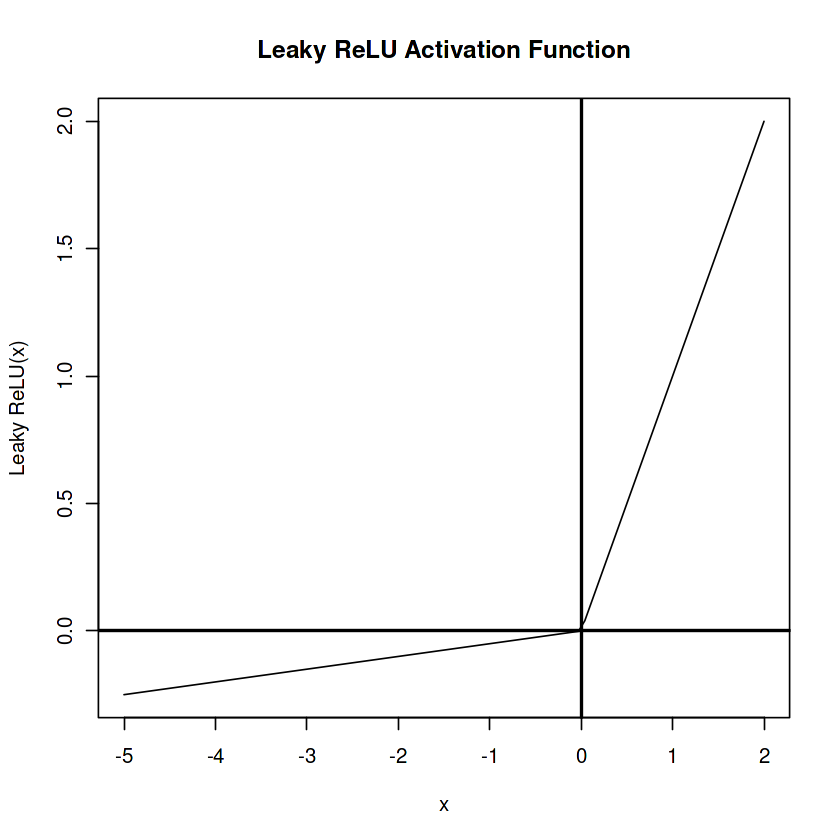

In [8]:
leaky_relu <- function(x, alpha = 0.05) {
  ifelse(x > 0, x, alpha * x)
}

curve(leaky_relu, from = -5, to = 2, xlab = "x", ylab = "Leaky ReLU(x)", main = "Leaky ReLU Activation Function")
abline(h = 0, v = 0, col = "black", lwd = 2)

### Softmax Activation Function
The softmax activation function is used to convert the output of the<br>
neural network into a probability distribution. Softmax essentially<br> 
predicts the probability that an observation belongs to a particular<br> 
class. The softmax function is defined as follows:<br>

\begin{equation} Softmax(z) = \frac{e^{z_{i}}}{\sum_{j=1}^{Q} e^{z_{j}}} \end{equation}

As previously stated:<br>
\begin{equation} NumberClasses  = Q = 10 \end{equation} 

For better numerical stability, the softmax function is modified as follows:<br>

\begin{equation} Softmax(z)_{Max}  = \frac{e^{z_{i} - max(z)}}{\sum_{j=1}^{Q} e^{z_{j} - max(z)}} \end{equation}

Taking log of both sides:<br>

\begin{equation} ln[Softmax(z)_{Max}] = ln\left(\frac{e^{z_{i} - max(z)}}{\sum_{j=1}^{Q} e^{z_{j} - max(z)}}\right) \end{equation}

Apply the log identity to the softmax function:<br>

\begin{equation} ln(\frac{a}{b}) =ln(a) - ln(b) \end{equation}

\begin{equation} ln(Softmax(z)_{Max}) =  ln\left[e^{z_{i} - max(z)}\right] - ln\left[\sum_{j=1}^{Q} e^{z_{j} - max(z)}\right] \end{equation}

\begin{equation} ln(Softmax(z)_{Max}) =  z_{i} - max(z) - ln\left[\sum_{j=1}^{Q} e^{z_{j} - max(z)}\right] \end{equation}

\begin{equation} e^{ln(Softmax(z)_{Max})}  = e^{z_{i} - \max(z) - ln\left[\sum_{j=1}^{Q} e^{z_{j} - max(z)}\right]} \end{equation}

After some algebraic manipulation, the final version of the softmax function is redefined<br>
as follows:<br>

\begin{equation} Softmax(z)_{Max}  = e^{z_{i} - \max(z) - ln\left[\sum_{j=1}^{Q} e^{z_{j} - max(z)}\right]} \end{equation}

### One Hot Encoding Matrix
The output of the NN is a vector of 10 probabilities, each probability<br>
represents the probability of the image being a digit from 0 to 9. But<br>
Y_Labels is not a vector of probabilities, it's a vector of digits. Hence,<br> 
Y_Labels needs to be converted into a vector of probabilities. This is<br>
done by using one-hot encoding.<br>

Since I set the columns of the X1 matrix to be observations. Then each<br>
column of the one hot encoding matrix is also an observation. The one hot<br>
encoding matrix is a matrix of zeros with only a single 1 in each column.<br>
Mathematically you can think of each column as a basis vector. In other<br>
words, each column is a vector of zeros with only a single 1. The position<br>
of the 1 represents the class. Thus each column represents an observation.<br>
Neural network is trained to classify images of digits from 0 to 9. Thus<br>
row 1 represents digit 0, row 2 represents digit 1, row 3 represents<br>
digit 2, so on and so forth. Example of one hot encoding matrix for Q=10<br> 
classes and n=5 observations is as follows:<br>

\begin{equation} Y_{Q \; x \; n} = \text{One Hot Encoding Matrix} \end{equation}<br>

\begin{equation} Y_{Q \; x \; n} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & 0 & 1 \\ 
0 & 0 & 1 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 \\ 
\end{bmatrix} \end{equation}<br>

One Hot Encoding Training Data<br>

In [9]:
# Initialize a list to store the basis vectors
basis_vectors_list_training <-list()

# Loop over each column of the matrix
for (q in 1:N_training) {
  # Get the label for the q-th column
  label <- Y_Labels_training[1, q] %>% as.numeric()
  
  # Create a vector of zeros with length Q
  basis_vectors_training <- rep(0, Q)
  
  # Set the (label+1)-th element to 1
  basis_vectors_training[label + 1] <-1
  
  # Add the basis vector to the list
  basis_vectors_list_training[[q]] <-basis_vectors_training %>% as.matrix()
}

# Convert the list of basis vectors to a matrix
Y_One_Hot_Encoding_training <- do.call(cbind, basis_vectors_list_training)

One Hot Encoding Testing Data<br>

In [10]:
# Initialize a list to store the basis vectors
basis_vectors_list_testing <-list()

# Loop over each column of the matrix
for (q in 1:N_testing) {
  # Get the label for the q-th column
  label <-Y_Labels_testing[1, q] %>% as.numeric()
  
  # Create a vector of zeros with length Q
  basis_vectors_testing <-rep(0, Q)
  
  # Set the (label+1)-th element to 1
  basis_vectors_testing[label + 1] <-1
  
  # Add the basis vector to the list
  basis_vectors_list_testing[[q]] <-basis_vectors_testing %>% as.matrix()
}

# Convert the list of basis vectors to a matrix
Y_One_Hot_Encoding_testing <- do.call(cbind, basis_vectors_list_testing)

### Categorical Cross Entropy Loss Function
The output from the softmax function is passed to the categorical cross<br>
entropy loss function. The purpose of the categorical cross entropy loss<br>
function is to measure the difference between the predicted probabilities<br>
and the actual probabilities. Note that the hollow circle means hadamard<br>
product (element-wise multiplication). After the hadamard product, the<br>
categorical cross entropy loss function is summed across **Q** classes<br> 
and then summed over **n** observations. Finally, the sum is divided by<br> 
the number of observations. The mean categorical cross entropy loss<br> 
function is defined as follows:<br>

\begin{equation} C_{mean} = -\frac{1}{n} \sum^{n} \sum^{Q} [Y_{Q \; x \; n} \circ \ln(X_{out})_{Q \; x \; n}] \end{equation}<br>

\begin{equation} C_{mean} = -mean\left[ \sum^{Q} [Y_{Q \; x \; n} \circ \ln(X_{out})_{Q \; x \; n}] \right] \end{equation}<br>

Cost function for each observation is a vector.<br>
\begin{equation} C_{vector} = C_{v} = -[y_{v} \circ \ln(x_{out})_{v}] \end{equation}<br>

All cost function vectors make up the cost function matrix.<br>
\begin{equation} C_{Matrix} = C_{M} = -Y_{Q \; x \; n} \circ \ln(X_{out})_{Q \; x \; n} \end{equation}

### Feedforward Summary
\begin{equation} NumberPixels  = 784 \end{equation}<br>
\begin{equation} NumberObservations  = n \end{equation}<br>
\begin{equation} NumberClasses  = Q = 10 \end{equation}<br>

#### When Using One Hidden Layer
\begin{equation} \text{Number Hidden Neurons}= nu \end{equation} <br>

\begin{equation} Xi_{784 \; x \; n}  \underset{bias}{\rightarrow}  (X1)_{(784+1) \; x \; n}   \end{equation} <br>
\begin{equation} (M1)_{nu \; x \; 785} * (X1)_{785 \; x \; n}  = (Z2)_{nu \; x \; n} \end{equation}<br>
\begin{equation} LR[(Z2)]_{nu \; x \; n}  \underset{bias}{\rightarrow}  (X2)_{(nu+1) \; x \; n}   \end{equation}<br>
\begin{equation} (M2)_{Q \; x \; (nu+1)} * (X2)_{(nu+1) \; x \; n}  = (Z3)_{Q \; x \; n} \end{equation}<br>
\begin{equation} (Z3)_{Q \; x \; n}  = (Z_{out})_{Q \; x \; n}\end{equation}<br>

#### When Using Two Hidden Layers
\begin{equation} \text{Number Hidden Neurons 1st layer }= nu \end{equation} <br> 
\begin{equation} \text{Number Hidden Neurons 2nd layer }= nu2 \end{equation} <br>

\begin{equation} Xi_{784 \; x \; n}  \underset{bias}{\rightarrow}  (X1)_{(784+1) \; x \; n}   \end{equation}<br>
\begin{equation} (M1)_{nu \; x \; 785} * (X1)_{785 \; x \; n}  = (Z2)_{nu \; x \; n} \end{equation}<br>
\begin{equation} LR[(Z2)]_{nu \; x \; n}  \underset{bias}{\rightarrow}  (X2)_{(nu+1) \; x \; n}   \end{equation}<br>
\begin{equation} (M2)_{nu2 \; x \; (nu+1)} * (X2)_{(nu+1) \; x \; n}  = (Z3)_{nu2 \; x \; n} \end{equation}<br>
\begin{equation} LR[(Z3)]_{nu2 \; x \; n}  \underset{bias}{\rightarrow}  (X3)_{(nu2+1) \; x \; n}   \end{equation}<br>
\begin{equation} (M3)_{Q \; x \; (nu2+1)} * (X3)_{(nu2+1) \; x \; n}  = (Z4)_{Q \; x \; n} \end{equation}<br>
\begin{equation} (Z4)_{Q \; x \; n}  = (Z_{out})_{Q \; x \; n}\end{equation}<br>

#### Output Layer
\begin{equation} [Softmax(Z_{out})_{Max}]_{Q \; x \; n}  = (X_{out})_{Q \; x \; n} \end{equation}<br>

\begin{equation} C_{Matrix} = C_{M} = -Y_{Q \; x \; n} \circ \ln(X_{out})_{Q \; x \; n} \end{equation}<br>
\begin{equation} C_{mean} = -mean\left[ \sum^{Q} [Y_{Q \; x \; n} \circ \ln(X_{out})_{Q \; x \; n}] \right] \end{equation}<br>

## Backpropagation 
This is where the magic happens. Backpropagation is where the neural<br> 
network learns. The neural network learns by minimizing the cost function.<br> 
The cost function is minimized by calculating the gradient of the cost<br> 
function with respect to the M weight matrices. The gradient of the cost<br> 
function is calculated by using the chain rule. The chain rule is used to<br> 
calculate the partial derivatives of the cost function with respect to<br> 
the M weight matrices. Backpropagation is nothing more than finding the<br> 
partial derivative of the cost function with respect to the M weight<br> 
matrices.I did this via the partial derivative tree diagram. The partial<br> 
derivative tree diagram is a visual representation of the chain rule.<br>

### One Hidden Layer
#### Derivative of The C Cost Matrix With Respect to The M2 Weight Matrix

\begin{equation} \frac{\partial C}{\partial M2} = \left( \frac{\partial C^T}{\partial X3} * \frac{\partial X3^T}{\partial Z3} \right)^T * \frac{\partial Z3}{\partial M2} \end{equation}<br>

where:<br>

\begin{equation} \left(\frac{\partial C^T}{\partial X3} * \frac{\partial X3^T}{\partial Z3}\right)^T = (X3 - Y)_{Q \; x \; n} \end{equation}<br>

\begin{equation} \frac{\partial Z3}{\partial M2} = (X2^T)_{n \; x \; (nu +1)} \end{equation}<br>

thus:<br>

\begin{equation} \frac{\partial C}{\partial M2} = (X3 - Y)_{Q \; x \; n} * (X2^T)_{n \; x \; (nu+1)} \end{equation}<br>

The matrix (X3 - Y) is obtained by the matrix multiplication of the softmax<br>
Jabobian matrix with the derivative of the C cost vector with respect to<br>
the output softmax vector.<br>

For sanity check, the size of the M2 weight matrix must equal the size of<br>
the derivative of the C cost matrix with respect to the M2 weight matrix.<br>

Size of M2 matrix is:<br>

\begin{equation} (M2)_{size}= Q \; x \; (nu+1) \end{equation}<br>

\begin{equation} \frac{\partial C}{\partial M2}_{size} = (Q \; x \; n) * (n \; x \; (nu+1)) \end{equation}<br>
\begin{equation} \frac{\partial C}{\partial M2}_{size} = Q \; x \; (nu+1) \end{equation}<br>

\begin{equation} (M2)_{size} = \frac{\partial C}{\partial M2}_{size} \end{equation}<br>

#### Derivative of The C Cost Matrix With Respect to The M1 Weight Matrix

\begin{equation} \frac{\partial C}{\partial M1} = \left[ \left( \left( \frac{\partial C^T}{\partial X3} * \frac{\partial X3^T}{\partial Z3} \right) * \frac{\partial Z3}{\partial X2} \right)^T \circ \frac{\partial X2}{\partial Z2} \right] * \frac{\partial Z2}{\partial M1}\end{equation}<br>

where:<br>

\begin{equation} \left( \frac{\partial C^T}{\partial X3} * \frac{\partial X3^T}{\partial Z3} \right) = (X3 - Y)^T_{n \; x \; Q} \end{equation}<br>

\begin{equation} \frac{\partial Z3}{\partial X2}= (M2_{-b})_{Q \; x \; nu} \end{equation} <br>

The subscript -b means that the bias column is removed from the M2 weight<br>
matrix. Note that leaky ReLU LR(z) = x2. The bias weights are multiplied<br>
by 1, hence there is no LR(z) activation function in the bias node. Thus<br>
when you take the derivative of the Z3 matrix with respect to the X2<br>
matrix, the bias column is removed because the bias node has no x2<br>
activation function. The derivative dZ3/dX2= 0 for the bias column.<br>

You also have:<br>

\begin{equation} \frac{\partial X2}{\partial Z2} = {[\partial LR(X2_{-b})}]_{nu \; x \; n}\end{equation}<br>

Similarly, the subscript -b means that the bias row is removed from the<br>
X2 matrix. The bias node has only ones, which are not dependent on previous<br>
weights. Thus, when you take the derivative of the X2 matrix with respect<br>
to the Z2 matrix, the bias row is removed because the bias node is not<br>
connected to previous nodes. The derivative dX2/dZ2= 0 for the bias row.<br>

You finally have:<br>

\begin{equation} \frac{\partial Z2}{\partial M1}= X1^T_{n \; x \; 785} \end{equation}<br>


Thus you have:<br>

\begin{equation} \frac{\partial C}{\partial M1} = [[(X3 - Y)^T * M2_{-b}]^T \circ \partial LR(X2_{-b})] * X1^T \end{equation}<br>

Again for sanity check, the size of the M1 weight matrix must equal the<br>
size of the derivative of the C cost matrix with respect to the M1 weight<br>

Size of M1 matrix is:<br>

\begin{equation} (M1)_{size}= nu \; x \; 785\end{equation}<br>

\begin{equation} \frac{\partial C}{\partial M1}_{size} = [[(n \; x \; Q)*(Q \; x \; nu)]^T \circ (nu \; x \; n)] * (n \; x \; 785) \end{equation}
\begin{equation}                               = [(n \; x \; nu)^T \circ (nu \; x \; n)] * (n \; x \; 785)\end{equation}
\begin{equation}                               = [(nu \; x \; n) \circ (nu \; x \; n)] * (n \; x \; 785)\end{equation}
\begin{equation}                               = (nu \; x \; n) * (n \; x \; 785)\end{equation}
\begin{equation} \frac{\partial C}{\partial M1}_{size} = nu \; x \; 785\end{equation}

\begin{equation} (M1)_{size} = \frac{\partial C}{\partial M1}_{size}\end{equation}<br>

### Two Hidden Layers
#### Derivative of The C Cost Matrix With Respect to The M3 Weight Matrix
\begin{equation} \frac{\partial C}{\partial M3} = \left( \frac{\partial C^T}{\partial X4} * \frac{\partial X4^T}{\partial Z4} \right)^T * \frac{\partial Z4}{\partial M3} \end{equation}<br>

\begin{equation} \frac{\partial C}{\partial M3} = (X4 - Y)_{Q \; x \; n} * (X3)_{n \; x \; (nu2+1)}^T \end{equation}<br>

where:<br>

\begin{equation} \left(\frac{\partial C}{\partial Z4}\right)^T = (X4 - Y)_{Q \; x \; n} \end{equation}<br>

For sanity check, the size of the M3 weight matrix must equal the size of<br>
the derivative of the C cost matrix with respect to the M3 weight matrix.<br>

Size of M3 matrix is:<br>

\begin{equation} (M3)_{size}= Q \; x \; (nu2+1) \end{equation}<br>

\begin{equation} \frac{\partial C}{\partial M3}_{size} = (Q \; x \; n) * (n \; x \; (nu2+1))\end{equation}<br>
\begin{equation} \frac{\partial C}{\partial M3}_{size} = Q \; x \; (nu2+1)\end{equation}<br>

\begin{equation} (M3)_{size} = \frac{\partial C}{\partial M2}_{size}\end{equation}<br>

#### Derivative of The C Cost Matrix With Respect to The M2 Weight Matrix
\begin{equation} \frac{\partial C}{\partial M2} = \left[ \left( \left( \frac{\partial C^T}{\partial X4} * \frac{\partial X4^T}{\partial Z4} \right) * \frac{\partial Z4}{\partial X3} \right)^T \circ \frac{\partial X3}{\partial Z3} \right] * \frac{\partial Z3}{\partial M2}\end{equation}<br>
\begin{equation} \frac{\partial C}{\partial M2} = \left[ \left( \left(\frac{\partial C}{\partial Z4}\right) * \frac{\partial Z4}{\partial X3} \right)^T \circ \frac{\partial X3}{\partial Z3} \right] * \frac{\partial Z3}{\partial M2}\end{equation}<br>

where:<br>

\begin{equation} \frac{\partial C}{\partial Z3} = \left( \left(\frac{\partial C}{\partial Z4}\right) * \frac{\partial Z4}{\partial X3} \right)^T  \circ \frac{\partial X3}{\partial Z3} \end{equation}<br>

Then:<br>

\begin{equation} \frac{\partial Z4}{\partial X3}= (M3_{-b})_{Q \; x \; nu2} \end{equation} <br>

\begin{equation} \frac{\partial X3}{\partial Z3}= {[\partial LR(X3_{-b})}]_{nu2 \; x \; n}\end{equation}<br>

\begin{equation} \frac{\partial Z3}{\partial M2}= X2^T_{n \; x \; (nu+1)} \end{equation}<br>

Thus you have:<br>
\begin{equation} \frac{\partial C}{\partial M2} = \left[\left(\frac{\partial C}{\partial Z4} * M3_{-b}\right)^T \circ \partial LR(X3_{-b})\right] * X2^T \end{equation}<br>
\begin{equation} \frac{\partial C}{\partial M2} = [[(X4 - Y)^T * M3_{-b}]^T \circ \partial LR(X3_{-b})] * X2^T \end{equation}<br>

The size of the M2 weight matrix must equal the size of the derivative of<br> 
the C cost matrix with respect to the M2 weight<br>

Size of M2 matrix is:<br>

\begin{equation} (M2)_{size}= nu2 \; x \; (nu + 1)\end{equation}<br>

\begin{equation} \frac{\partial C}{\partial M2}_{size} = [[(n \; x \; Q)*(Q \; x \; nu2)]^T \circ (nu2 \; x \; n)] * (n \; x \; (nu+1))\end{equation}
\begin{equation}                               = [(n \; x \; nu2)^T \circ (nu2 \; x \; n)] * (n \; x \; (nu+1))\end{equation}
\begin{equation}                               = [(nu2 \; x \; n) \circ (nu2 \; x \; n)] * (n \; x \; (nu +1))\end{equation}
\begin{equation}                               = (nu2 \; x \; n) * (n \; x \; (nu +1))\end{equation}
\begin{equation}\frac{\partial C}{\partial M2}_{size} = nu2 \; x \; (nu +1)\end{equation}

\begin{equation}(M2)_{size} = \frac{\partial C}{\partial M2}_{size}\end{equation}<br>

#### Derivative of The C Cost Matrix With Respect to The M1 Weight Matrix
\begin{equation} \frac{\partial C}{\partial M1} = \left[\left[\left[ \left( \left( \frac{\partial C^T}{\partial X4} * \frac{\partial X4^T}{\partial Z4} \right) * \frac{\partial Z4}{\partial X3} \right)^T \circ \frac{\partial X3}{\partial Z3} \right]^T * \frac{\partial Z3}{\partial X2}\right]^T \circ \frac{\partial X2}{\partial Z2}\right] * \frac{\partial Z2}{\partial M1}\end{equation}

\begin{equation}\frac{\partial C}{\partial M1} = \left[\left[ \left(\frac{\partial C}{\partial Z3}\right)^T * \frac{\partial Z3}{\partial X2}\right]^T \circ \frac{\partial X2}{\partial Z2}\right] * \frac{\partial Z2}{\partial M1}\end{equation}<br>

where:<br>

\begin{equation} \frac{\partial Z3}{\partial X2}= (M2_{-b})_{nu2 \; x \; nu} \end{equation}<br>

\begin{equation} \frac{\partial X2}{\partial Z2}= {[\partial LR(X2_{-b})}]_{nu \; x \; n}\end{equation}<br>

\begin{equation} \frac{\partial Z2}{\partial M1}= X1^T_{n \; x \; 785} \end{equation}<br>

Thus:<br>

\begin{equation} \frac{\partial C}{\partial M1} = \left[\left[ \left(\frac{\partial C}{\partial Z3}\right)^T * M2_{-b}\right]^T \circ \partial LR(X2_{-b})\right] * X1^T \end{equation}<br>

The size of the M1 weight matrix must equal the size of the derivative of<br> 
the C cost matrix with respect to the M1 weight<br>

Size of M1 matrix is:<br>

\begin{equation} (M1)_{size}= nu \; x \; 785\end{equation}<br>

\begin{equation} \frac{\partial C}{\partial M1}_{size} = [[(n \; x \; nu2)*(nu2 \; x \; nu)]^T \circ (nu \; x \; n)] * (n \; x \; 785)\end{equation}
\begin{equation}                               = [(n \; x \; nu)^T \circ (nu \; x \; n)] * (n \; x \; 785)\end{equation}
\begin{equation}                               = [(nu \; x \; n) \circ (nu \; x \; n)] * (n \; x \; 785)\end{equation}
\begin{equation}                               = (nu \; x \; n) * (n \; x \; 785)\end{equation}
\begin{equation}\frac{\partial C}{\partial M1}_{size} = nu \; x \; 785\end{equation}

\begin{equation}(M1)_{size} = \frac{\partial C}{\partial M1}_{size} \end{equation}

## Gradient Descent
Gradient descent is applied at the end of backpropagation. Gradient<br>
descent is an algorithm that minimizes the cost function by iteratively<br> 
updating the M weight matrices. The M weight matrices are updated by<br>
subtracting the M weight matrix by the gradient of the cost function with<br> 
respect to the M weight matrices multiplied by the learning rate. The<br> 
learning rate is a hyperparameter that determines the size of the step<br> 
taken in the direction of the gradient. The learning rate is a<br> 
hyperparameter that needs to be tuned. If the learning rate is too small,<br>
then the algorithm will take a long time to converge. If the learning<br> 
rate is too large, then the algorithm will diverge.<br>

### Basic Gradient Descent Algorithm
\begin{equation} M_{t+1} = M_{t} - \alpha \nabla f(M_{t}) \end{equation}

\begin{equation} \alpha = \text{learning rate set through trial and error} \end{equation}

#### One Hidden Layer
For the M2 weight matrix:<br>
\begin{equation} (M2)_{t+1} = (M2)_{t} - \alpha \frac{\partial C}{\partial M2} \end{equation}

For the M1 weight matrix:<br>
\begin{equation} (M1)_{t+1} = (M1)_{t} - \alpha \frac{\partial C}{\partial M1} \end{equation}

#### Two Hidden Layers
For the M3 weight matrix:<br>
\begin{equation} (M3)_{t+1} = (M3)_{t} - \alpha \frac{\partial C}{\partial M3} \end{equation}

For the M2 weight matrix:<br>
\begin{equation} (M2)_{t+1} = (M2)_{t} - \alpha \frac{\partial C}{\partial M2} \end{equation}

For the M1 weight matrix:<br>
\begin{equation} (M1)_{n+1} = (M1)_{t} - \alpha \frac{\partial C}{\partial M1} \end{equation}

### Gradient Descent With Decaying Learning Rate
Basically the same as the basic gradient descent algorithm, except the<br>
learning rate is decaying with each iteration/epoch. Variable t stands<br> 
for the iteration/epoch number. Where t can refer to the iteration if<br> 
using SGD or Mini-batch GD. Variable t can refer to the epoch if using<br>
Batch GD. The learning rate is decaying by a factor of 1/t.<br> 

\begin{equation} \alpha = \alpha_{1}*(1/t) \end{equation}

\begin{equation} \alpha_{1} = \text{learning rate alpha1 set through trial and error} \end{equation}

\begin{equation} M_{t+1} = M_{t} - \alpha \nabla f(M_{t}) \end{equation}

### Gradient Descent With Adam Optimizer
Adam optimizer is a combination of RMSprop and momentum. Adam optimizer<br>
is a more advanced gradient descent algorithm. Adam optimizer is more<br>
stable and converges faster than basic gradient descent. Adam optimizer<br>
is the recommended gradient descent algorithm for neural networks. Beta1 is<br> 
typically set to 0.9. Beta2 is typically set to 0.999. Epsilon is typically<br>
set to 10^-8. Adam optimzer is defined as follows:<br>

\begin{equation} M_{t} = M_{t-1} - \alpha \frac{\hat{v1}_{t}}{\sqrt{\hat{v2}_{t}} + \epsilon} \end{equation}

Initialize:<br>

\begin{equation} v1_{0} = 0 \leftarrow \text{Initialize 1st Momentum} \end{equation}
\begin{equation} v2_{0} = 0 \leftarrow \text{Initialize 2nd Momentum} \end{equation}
\begin{equation} t_{0} = 0 \leftarrow \text{Initialize timestep} \end{equation}
\begin{equation} \beta_{1} = 0.9 \end{equation}
\begin{equation} \beta_{2} = 0.999 \end{equation}
\begin{equation} \epsilon = 10^{-8} \end{equation}
\begin{equation} \alpha = \text{learning rate set through trial and error} \end{equation}

Note v at (t-1) is the momentum from the previous iteration/epoch. 1st and<br> 
2nd momentum at any time step t is defined as follows.<br>

\begin{equation} v1_{t} = \beta_{1}v1_{t-1} + \left[(1-\beta_{1})\nabla f(M_{t-1})\right] \end{equation}

\begin{equation} v2_{t} = \beta_{2}v2_{t-1} + \left[(1-\beta_{2}) \left[\nabla f(M_{t-1})\right]^2\right] \end{equation}

\begin{equation} \left[\nabla f(M_{t-1})\right]^2 = \nabla f(M_{t-1}) \circ \nabla f(M_{t-1})\end{equation} 


Note that Beta1 and Beta2 are raised to the power of t. Hence if t=3, then<br>
(Beta1)^3 and (Beta2)^3. Bias-corrected 1st and 2nd momentum at any time<br>
step t is defined as follows:<br>

\begin{equation} \hat{v1}_{t} = \frac{v1_{t}}{1-\beta_{1}^{t}} \end{equation}
\begin{equation} \hat{v2}_{t} = \frac{v2_{t}}{1-\beta_{2}^{t}} \end{equation}

#### One Hidden Layer Adam Optimizer for M2 Weight Matrix 
For the M2 weight matrix Initialize v1, v2, and t to 0. Then 1st and<br> 
2nd momentum at any time step t for M2 matrix.<br>

\begin{equation} v1_{t} = \beta_{1}v1_{t-1} + \left[(1-\beta_{1})\frac{\partial C}{\partial M2}\right] \end{equation}

\begin{equation} v2_{t} = \beta_{2}v2_{t-1} + \left[(1-\beta_{2}) \left[\frac{\partial C}{\partial M2}\right]^2\right] \end{equation}

\begin{equation} \left[\frac{\partial C}{\partial M2}\right]^2 = \frac{\partial C}{\partial M2} \circ \frac{\partial C}{\partial M2}\end{equation}

Then calculate Bias-corrected 1st and 2nd momentum at any time step t for M2<br> 
matrix.<br>

\begin{equation} \hat{v1}_{t} = \frac{v1_{t}}{1-\beta_{1}^{t}} \end{equation}
\begin{equation} \hat{v2}_{t} = \frac{v2_{t}}{1-\beta_{2}^{t}}  \end{equation}

Finally, the M2 weight matrix is updated.<br>

\begin{equation} M2_{t} = M2_{t-1} - \alpha \frac{\hat{v1}_{t}}{\sqrt{\hat{v2}_{t}} + \epsilon} \end{equation}

Note that $\hat{v1}_{t}$ and $\hat{v2}_{t}$ are matrices with same dimension as M2. Hence in the formula, $\frac{\hat{v1}_{t}}{\sqrt{\hat{v2}_{t}} + \epsilon}$<br>
represents element-wise division, where each element in $\hat{v1}_{t}$ is divided by the corresponding element in $\sqrt{\hat{v2}_{t}} + \epsilon$.<br>


## Training and Accuracy of Neural Network
### Training Phase
What is the training phase for NN? The training phase is composed of<br>
feedforward, backpropagation, then gradient descent. Then start over<br> 
again. Feedforward, backpropagation, and finally gradient descent. So on<br> 
and so forth. One iteration of feedforward, backpropagation, and gradient<br>
descent through every single observation is called an epoch.So then, after<br> 
how many epochs do you need to stop training? Training stoppage is<br> 
determined by the most optimal solution from the testing dataset. Once the<br> 
minima for the testing data is reached, training is optimized. The minima<br>
for the testing data is determined by the mean categorical cross entropy<br>
loss function.<br>

### Accuracy of Neural Network
$X_{out}$ is the output probability. Each column is an observation. Assuming<br>
that the highest predicted class from each column represents the model's<br> 
final classification decision. Then extracting the highest probability<br>
from each column, $(X_{out})_{highest}$ is a vector with the highest<br>
probability for each column.<br>

\begin{equation} X_{out} \underset{collapse\;vector}{\rightarrow} [(X_{out})_{highest}]_{1 \; x \;n}  \end{equation}

$Y$ is the one hot encoding matrix which contains all one hot encoding<br>
vectors. Matrix $Y$ contains all the correct probabilities for each<br>
observation. In theory, if 100% accuracy was ever reached, then element<br> 
wise multiplication of $X_{out} \circ Y= X_{out}$. But if 100% accuracy<br>
is not reached, then $X_{out} \circ Y \neq X_{out}$. The difference between<br>
$X_{out} \circ Y$ and $X_{out}$ is the error. The error is the difference between<br>
the predicted probability and the correct probability. $X_{out} \circ Y$ has mostly<br>
zeros. Each column only contains one non zero value. Hence if you collapse<br>
$X_{out} \circ Y$ into a vector. The collapsed vector contains the correct<br>
predictions and the incorrect predictions for all observations.<br>

\begin{equation} (X_{out})_{Q \; x \; n} \circ Y_{Q \; x \; n} \underset{collapse\;vector}{\rightarrow} [(X_{out} \circ Y)_{v}]_{1 \; x \;n} \end{equation}

We can find out the correct prediction for each observation by subtracting<br>
$[(X_{out} \circ Y)_{v}]_{1 \; x \;n}$ by $[(X_{out})_{highest}]_{1 \; x \;n}$. The zeros in the vector<br> 
means the NN made the correct prediction for that observation. The non<br> 
zero values in the vector means the NN made the incorrect prediction for<br>
that observation.<br>

\begin{equation} [[(X_{out})_{highest}]_{1 \; x \;n} - (X_{out} \circ Y)_{v}]_{1 \; x \;n}\end{equation}

Count number of zeros to obtain the number of correct predictions.<br>

\begin{equation} count([[(X_{out})_{highest}]_{1 \; x \;n} - (X_{out} \circ Y)_{v}]_{1 \; x \;n})\end{equation}

Thus accuracy = (count)(100%)/n, where n=total number of observations.<br>

\begin{equation} Accuracy \; \% = \frac{count}{n} * 100\%  \end{equation}

## Setting Up Model Parameters and Data Structures
### Tunenable Hyperparameters

In [11]:
# "No mapping" = No mapping
# "Feature Mapping" = Fourier Feature Mapping
NoMapping_vs_FourierFeatureMapping <-"No mapping"

# Sigma value for Gaussian distribution for Fourier Feature Mapping
sigma <-60

#hyperparameter for learning rate
Alpha_ONE <-10^-3

#Beta1
Beta1 <-0.9

#Beta2
Beta2 <-0.999

#Epsilon
Epsilon <-10^-8

# Initialize 1st moment at t=1
v1 <-0

# Initialize 2nd moment at t=1
v2 <-0

# GRADIENT DESCENT ALGORITHMS 
# "constant" = constant learning rate
# "decaying" = decaying learning rate (1/t)
#     "adam" = adam optimizer
gradient_descent_algorithm <-"adam"

#Number of training observations used in each batch.
# Set n=1 for SGD (1 observation)
# Set 1 <n< N_training for Mini-batch GD (more than 1, but less than all observations)
# Set n= N_training, Batch GD (All observation)
n <-350

# Setting LeakyReLU_alpha = 0 is the same as using ReLU.
LeakyReLU_alpha <-0.1

# 1 for one hidden layer and 2 for two hidden layers.
# Code is only set up for one or two hidden layers.
# Thus 1 and 2 are the only allowed values for num_hidden_layers.
num_hidden_layers <-1

# Code not set up for one neuron in hidden layer, thus n=1 is not allowed.
# Apart from that. Any other positive integer is allowed.
# Number of hidden neurons in 1st hidden layer.
nu <-100

# Same as other hidden layer, n=1 is not allowed.
# Number of hidden neurons in 2nd hidden layer.
nu2 <-20

if (n < N_training) {
##############################################
# SGD AND MINI BATCH GRADIENT DESCENT
###############################################
# Total number of observations for training
Tb <-N_training

# Number of observations per iteration
n_iteration <-n

# Number of batches = number of iterations per epoch
number_batches <-Tb/n_iteration
number_iterations_epoch <-number_batches

# Total Number of epochs
Epoch <-4

# (Epoch*number_iterations_epoch) = total number of iterations per epoch
Epochs <-Epoch*number_iterations_epoch

} else {
###############################################
#BATCH GRADIENT DESCENT
###############################################
# Total Number of epochs
Epochs <-3

}

In [12]:
# Code set for 3. DONT CHANGE. 3 Randomly selected numbers for feedforward prediction.
n_prediction <-3  

### Weight Matrices

In [13]:
if (num_hidden_layers < 2) {
##############################################
# ONE HIDDEN LAYER
###############################################
# Size of matrix M1.
M1_m_rows <-nu
M1_n_col <-ncol(Row_Image_Matrix_training) + 1

# Size of matrix X1.
X1_m_rows <-ncol(Row_Image_Matrix_training) + 1
X1_n_col <-n

# Size of matrix Z2.
Z2_m_rows <-nu
Z2_n_col <-n

# Size of LeakyReLU.
LeakyReLU_m_rows <-nu
LeakyReLU_n_col <-n

# Size of matrix M2.
M2_m_rows <-Q
M2_n_col <-nu + 1

# Size of matrix X2
# Add 1 to the number of rows of LeakyReLU to account for the bias.
X2_m_rows <-nu + 1
X2_n_col <-n

# Size of matrix Z3.
Z3_m_rows <-Q
Z3_n_col <-n

# Size of Softmax. Where softmax = X3 =X_out
X3_m_rows <-Q
X3_n_col <-n
} else {
##############################################
# TWO HIDDEN LAYERS
###############################################
# Size of matrix M1.
M1_m_rows <-nu
M1_n_col <- ncol(Row_Image_Matrix_training) + 1

# Size of matrix X1.
X1_m_rows <- ncol(Row_Image_Matrix_training) + 1
X1_n_col <-n

# Size of matrix Z2.
Z2_m_rows <-nu
Z2_n_col <-n

# Size of LeakyReLU.
LeakyReLU_m_rows <-nu
LeakyReLU_n_col <-n

# Size of matrix M2.
M2_m_rows <-nu2
M2_n_col <-nu + 1

# Size of matrix X2
# Add 1 to the number of rows of LeakyReLU to account for the bias.
X2_m_rows <-nu + 1
X2_n_col <-n

# Size of matrix Z3.
Z3_m_rows <-nu2
Z3_n_col <-n

# Size of LeakyReLU2.
LeakyReLU_2_m_rows <-nu2
LeakyReLU_2_n_col <-n

# Size of matrix M3.
M3_m_rows <-Q
M3_n_col <-nu2 + 1

# Size of matrix X3
X3_m_rows <-nu2 + 1
X3_n_col <-n

# Size of matrix Z4.
Z4_m_rows <-Q
Z4_n_col <-n

# Size of Softmax. Where softmax = X4 =X_out
X4_m_rows <-Q
X4_n_col <-n
}

Set seed is used to make sure that the same random numbers are generated<br>
each time the code is run.<br>

In [14]:
set.seed(123)

Weight matrices.<br>

In [15]:
# Define the standard deviation for weight initialization (e.g., 1e-1 for small values)
weight_sd <- 1e-1

if (num_hidden_layers < 2) {
  ###############
  # When using One Hidden Layer
  ###############
  M1 <- matrix(rnorm(M1_m_rows * M1_n_col, mean = 0, sd = weight_sd), nrow = M1_m_rows, ncol = M1_n_col)
  M2 <- matrix(rnorm(M2_m_rows * M2_n_col, mean = 0, sd = weight_sd), nrow = M2_m_rows, ncol = M2_n_col)
} else {
  ###############
  # When using Two Hidden Layers
  ###############
  M1 <- matrix(rnorm(M1_m_rows * M1_n_col, mean = 0, sd = weight_sd), nrow = M1_m_rows, ncol = M1_n_col)
  M2 <- matrix(rnorm(M2_m_rows * M2_n_col, mean = 0, sd = weight_sd), nrow = M2_m_rows, ncol = M2_n_col)
  M3 <- matrix(rnorm(M3_m_rows * M3_n_col, mean = 0, sd = weight_sd), nrow = M3_m_rows, ncol = M3_n_col)
}

### Organizing Neural Network Metrics with Lists and Dataframes
Create a list to store M matrix for each epoch.<br>

In [16]:
if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
M1_list <-vector("list", Epochs)
M2_list <-vector("list", Epochs)
} else {
###############
# When using Two Hidden Layers
###############
M1_list <-vector("list", Epochs)
M2_list <-vector("list", Epochs)
M3_list <-vector("list", Epochs)
}

Create an empty dataframe to store the mean categorical cross entropy loss<br>
for each epoch.<br>

In [17]:
if (n < N_training) {
#SGD and Mini Batch Gradient Descent
CCEntropy_Loss <-data.frame(iteration = numeric(Epochs), epoch = numeric(Epochs), CCEL_x_out = numeric(Epochs), CCEL_testing_x_out = numeric(Epochs))
} else {
#Batch Gradient Descent
CCEntropy_Loss <-data.frame(epoch = numeric(Epochs), CCEL_x_out = numeric(Epochs), CCEL_testing_x_out = numeric(Epochs))
}

Create an empty dataframe to store training and testing accuracy for each<br>
epoch.<br>

In [18]:
Accuracy_Percent <-data.frame(Training_percent = numeric(Epochs), Testing_percent = numeric(Epochs))

## Fourier Feature Mapping for Gradient Descent
### Sampling From a Gaussian Distribution With Mean 0 and Variance (sigma)^2
Ramdom sampled points are stored in B matrix.<br>

In [19]:
# Row size matrix X(data)
Xd_m_rows <-ncol(Row_Image_Matrix_training)

# B Matrix = Sample from the Gaussian distribution with mean 0 and variance sigma^2
B <- matrix(rnorm(Xd_m_rows * 1, mean = 0, sd = sigma), nrow = Xd_m_rows, ncol = 1)

# Hf is harmonic frequencies (1 2 3 4...#number pixels)
Hf <- matrix(seq(1, Xd_m_rows), nrow = Xd_m_rows, ncol = 1)

# B martrix for training data
if (n < N_training) {
#SGD and Mini Batch Gradient Descent
# bind column n_iteration times

B_training <- matrix(rep(B, n_iteration,), nrow = Xd_m_rows, ncol = n_iteration, byrow = FALSE)

Hf_training <- matrix(rep(Hf, n_iteration,), nrow = Xd_m_rows, ncol = n_iteration, byrow = FALSE)
} else {
#Batch Gradient Descent
# bind column N_training times
B_training <- matrix(rep(B, N_training,), nrow = Xd_m_rows, ncol = N_training, byrow = FALSE)  

Hf_training <- matrix(rep(Hf, N_training,), nrow = Xd_m_rows, ncol = N_training, byrow = FALSE)
}

######
# B matrix for testing data
B_testing <- matrix(rep(B, N_testing,), nrow = Xd_m_rows, ncol = N_testing, byrow = FALSE)

# Hf matrix for testing data
Hf_testing <- matrix(rep(Hf, N_testing,), nrow = Xd_m_rows, ncol = N_testing, byrow = FALSE)
######

######
# B matrix for data prediction
B_pred <- matrix(rep(B, n_prediction,), nrow = Xd_m_rows, ncol = n_prediction, byrow = FALSE)

# Hf matrix for data prediction
Hf_pred <- matrix(rep(Hf, n_prediction,), nrow = Xd_m_rows, ncol = n_prediction, byrow = FALSE)
######

# Hf*pi*B 
Hf_pi_B_training <-Hf_training*pi*B_training
Hf_pi_B_testing <-Hf_testing*pi*B_testing
Hf_pi_B_pred <-Hf_pred*pi*B_pred

### Fourier Feature Mapping for Batch Gradient Descent (Training Data)

In [20]:
if (n == N_training) {
# No mapping vs Fourier Feature Mapping
switch(NoMapping_vs_FourierFeatureMapping,
    "No mapping" = {
      X1_training <- Row_Image_Matrix_training %>% t()

      X1_map_vs_no_map <- X1_training
    },
    "Feature Mapping" = {
      # Xi = X1_training
      # Batch Gradient Descent
      X1_training <- Row_Image_Matrix_training %>% t()

      Hf_pi_B_Xi <- Hf_pi_B_training * X1_training

      # apply the cos to each element of the matrix
      cos_element_wise <- cos(Hf_pi_B_Xi)

      # apply the sin to each element of the matrix
      sin_element_wise <- sin(Hf_pi_B_Xi)
      ###############################################
      # Create a vector of alternating ones and zeros
      one_zero_V <- t(rep(c(1, 0), length.out = Xd_m_rows)) %>% as.matrix() 

      # Repeat and bind the vector into a matrix
      one_zero_M <- matrix(rep(one_zero_V, N_training,), nrow = Xd_m_rows, ncol = N_training, byrow = FALSE)  

      cos_matrix <- one_zero_M * cos_element_wise

      # Create a vector of alternating zeros and ones
      zero_one_V <- t(rep(c(0, 1), length.out = Xd_m_rows)) %>% as.matrix()

      # Repeat and bind the vector into a matrix
      zero_one_M <- matrix(rep(zero_one_V, N_training,), nrow = Xd_m_rows, ncol = N_training, byrow = FALSE)

      sin_matrix <- zero_one_M * sin_element_wise

      # Fourier Feature Mapping
      gamma_Xi <- cos_matrix + sin_matrix

      X1_map_vs_no_map <- gamma_Xi
         })
}

### Fourier Feature Mapping for SGD, Mini-Batch and Batch Gradient Descent (Testing Data)

In [21]:
# No mapping vs Fourier Feature Mapping
#########################
# No mapping vs Fourier Feature Mapping
switch(NoMapping_vs_FourierFeatureMapping,
       "No mapping" = {
    # Transpose to make each column an observation.
    X1_testing <- Row_Image_Matrix_testing %>% t()

    X1_map_vs_no_map_testing <-X1_testing
       },
       "Feature Mapping" = {
    #Xi = X1_testing
    X1_testing <-Row_Image_Matrix_testing %>% t()

    Hf_pi_B_Xi_testing <-Hf_pi_B_testing * X1_testing

    # apply the cos to each element of the matrix
    cos_element_wise_testing <-cos(Hf_pi_B_Xi_testing)

    # apply the sin to each element of the matrix
    sin_element_wise_testing <-sin(Hf_pi_B_Xi_testing)
    ###############################################
    # Create a vector of alternating ones and zeros
    one_zero_V_testing <- t(rep(c(1, 0), length.out = Xd_m_rows))  %>% as.matrix() 

    # Repeat and bind the vector into a matrix
    one_zero_M_testing <- matrix(rep(one_zero_V_testing, N_testing,), nrow = Xd_m_rows, ncol = N_testing, byrow = FALSE)  

    cos_matrix_testing <-one_zero_M_testing * cos_element_wise_testing

    # Create a vector of alternating zeros and ones
    zero_one_V_testing <- t(rep(c(0, 1), length.out = Xd_m_rows))  %>% as.matrix()

    # Repeat and bind the vector into a matrix
    zero_one_M_testing <- matrix(rep(zero_one_V_testing, N_testing,), nrow = Xd_m_rows, ncol = N_testing, byrow = FALSE)

    sin_matrix_testing <-zero_one_M_testing * sin_element_wise_testing

    # Fourier Feature Mapping
    gamma_Xi_testing <- cos_matrix_testing + sin_matrix_testing

    X1_map_vs_no_map_testing <-gamma_Xi_testing
       })

## Putting It All Together: Neural Network Code

In [22]:
# if n < N_training, then SGD and mini batch gradient descent
# if n = N_training, then batch gradient descent
#############################################################################################################
# SGD AND MINI BATCH GRADIENT DESCENT
#############################################################################################################
if (n < N_training) {

for (epoch in 1:Epochs) {
###############################################
# Data Preprocessing for Training Data
###############################################
###############################################
# Separate training
###############################################
# Randomly select n_iteration rows
# replace = TRUE means that the same row can be selected more than once.
# replace = FALSE means that the same row cannot be selected more than once.
Randomly_selected_rows <-sample(nrow(Data_training_scaled), n_iteration, replace = FALSE)


# Create a new matrix with the selected rows
if (n == 1) {
#SGD 
Data_training <-Data_training_scaled[Randomly_selected_rows, ] %>% as.matrix()  %>% t()
} else {
#Mini Batch Gradient Descent
Data_training <-Data_training_scaled[Randomly_selected_rows, ] 
}

###############################################
# Let's separate the **y** column and the **image vector columns**.
###############################################
#Training data
Y_Labels_training <-Data_training[, 1]  %>% as.matrix()  %>% t()

Row_Image_Matrix_training <-Data_training[, 2:ncol(Data_training)]  %>%  as.matrix()

###############################################
#One Hot Encoding Training Data
###############################################
# Initialize a list to store the basis vectors
basis_vectors_list_training <-list()

# Loop over each column of the matrix
for (q in 1:n_iteration) {
  # Get the label for the q-th column
  label <- Y_Labels_training[1, q] %>% as.numeric()
  
  # Create a vector of zeros with length Q
  basis_vectors_training <- rep(0, Q)
  
  # Set the (label+1)-th element to 1
  basis_vectors_training[label + 1] <-1
  
  # Add the basis vector to the list
  basis_vectors_list_training[[q]] <-basis_vectors_training %>% as.matrix()
}

# Convert the list of basis vectors to a matrix
Y_One_Hot_Encoding_training <- do.call(cbind, basis_vectors_list_training)
  ###############################################
  # Code for Training forward forward pass
  ###############################################
#########################
# No mapping vs Fourier Feature Mapping
switch(NoMapping_vs_FourierFeatureMapping,
       "No mapping" = {
X1_training <- Row_Image_Matrix_training %>% t()

X1_map_vs_no_map <-X1_training
       },
       "Feature Mapping" = {
#Xi = X1_training
if (n == 1) {
  # SGD 
  X1_training <- Row_Image_Matrix_training
} else {
  # Mini Batch Gradient Descent
  X1_training <- Row_Image_Matrix_training %>% t()
}

Hf_pi_B_Xi <-Hf_pi_B_training * X1_training

# apply the cos to each element of the matrix
cos_element_wise <-cos(Hf_pi_B_Xi)

# apply the sin to each element of the matrix
sin_element_wise <-sin(Hf_pi_B_Xi)
###############################################
# Create a vector of alternating ones and zeros
one_zero_V <- t(rep(c(1, 0), length.out = Xd_m_rows))  %>% as.matrix() 

# Repeat and bind the vector into a matrix
one_zero_M <- matrix(rep(one_zero_V, n_iteration,), nrow = Xd_m_rows, ncol = n_iteration, byrow = FALSE)  

cos_matrix <-one_zero_M * cos_element_wise

# Create a vector of alternating zeros and ones
zero_one_V <- t(rep(c(0, 1), length.out = Xd_m_rows))  %>% as.matrix()

# Repeat and bind the vector into a matrix
zero_one_M <- matrix(rep(zero_one_V, n_iteration,), nrow = Xd_m_rows, ncol = n_iteration, byrow = FALSE)

sin_matrix <-zero_one_M * sin_element_wise

# Fourier Feature Mapping
gamma_Xi <- cos_matrix + sin_matrix

X1_map_vs_no_map <-gamma_Xi
       })
#########################
# Add bias row. Row of 1's
if (n == 1) {
  # SGD 
switch(NoMapping_vs_FourierFeatureMapping,
       "No mapping" = {
  X1 <-rbind(t(X1_map_vs_no_map), c(1))
       },
       "Feature Mapping" = {
  X1 <-rbind(X1_map_vs_no_map, rep(1, ncol(X1_map_vs_no_map)))
      })

} else {

  # Mini Batch Gradient Descent
  X1 <-rbind(X1_map_vs_no_map, rep(1, ncol(X1_map_vs_no_map)))
}

Z2 <- M1 %*% X1

# LeakyReLU activation function
if (n == 1) {
  # SGD 
  LeakyReLU <- apply(Z2, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x)) %>% 
    as.matrix()
} else {
  # Mini Batch Gradient Descent
  LeakyReLU <- t(apply(Z2, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
    as.matrix()
}

X2 <- rbind(LeakyReLU, 1) %>% 
  as.matrix()

###############################################
# For one and two hidden layers
if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
Z_out <- M2 %*% X2

} else {
###############
# When using Two Hidden Layers
###############
Z3 <- M2 %*% X2

# LeakyReLU activation function
if (n == 1) {
  # SGD 
  LeakyReLU2 <- apply(Z3, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x)) %>% 
    as.matrix()
} else {
  # Mini Batch Gradient Descent
  LeakyReLU2 <- t(apply(Z3, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
    as.matrix()
}

X3 <- rbind(LeakyReLU2, 1) %>% 
  as.matrix()

Z_out <- M3 %*% X3
}
###############################################
# Define Softmax(Max)
softmax_MAX <- function(z) {
  # zi-max(z)
  zi_max <-z - max(z)
  # e^(zi-max(z))
  exp_zi_max <-exp(zi_max)
  # e^(zi-max(z)-log(sum(e^(zj-max(z)))
  exp(zi_max - log(sum(exp_zi_max)))
}

# note that:
# apply(Z_out, 1 ----means its row wise
# apply(Z_out, 2 ----means its column wise
# Apply the softmax function to each column
X_out <- apply(Z_out, 2, softmax_MAX)
###############################################
# Code for Testing forward forward pass
###############################################
# Add bias row. Row of 1's
X1_test <-rbind(X1_map_vs_no_map_testing, rep(1, ncol(X1_map_vs_no_map_testing)))

Z2_testing <- M1 %*% X1_test

LeakyReLU_testing <- t(apply(Z2_testing, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
    as.matrix()

X2_testing <- rbind(LeakyReLU_testing, 1) %>% 
  as.matrix()
###############################################
# For one and two hidden layers
if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
Z_out_testing <- M2 %*% X2_testing

} else {
###############
# When using Two Hidden Layers
###############
Z3_testing <- M2 %*% X2_testing

LeakyReLU2_testing <- t(apply(Z3_testing, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
    as.matrix()

X3_testing <- rbind(LeakyReLU2_testing, 1) %>% 
  as.matrix()

Z_out_testing <- M3 %*% X3_testing
}

# Apply the softmax function to each column
X_out_testing <- apply(Z_out_testing, 2, softmax_MAX)

  ###############################################
  # Code for backpropagation training
  ###############################################
if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
  ###############
  # DC/DM2
  ###############
  dc_dX_out_t_times_dX_out_dZ3_out_t <- (X_out - Y_One_Hot_Encoding_training) %>% as.matrix()

  dZ3_out_dM2 <- t(X2)

  # dC/dM2 = [(dC/dX_out)^t *(dX_out/dZ3_out)^t]^t * dZ3_out/dM2
  dC_dM2 <- dc_dX_out_t_times_dX_out_dZ3_out_t %*% dZ3_out_dM2 %>% as.matrix()

  ###############
  # DC/DM1
  ###############
  # (dC/dX_out)^t *(dX_out/dZ3_out)^t
  dc_dX_out_t_times_dX_out_dZ3_out_t_t <- t(dc_dX_out_t_times_dX_out_dZ3_out_t)

  dZ3_out_dX2 <- M2[, -ncol(M2)] %>% as.matrix()

  # dX2/dZ2 (element wise)
  if (n == 1) {
    # SGD 
    dX2_dZ2_element_wise <- apply(X2, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha)) %>% as.matrix()
  } else {
    # Mini Batch Gradient 
    dX2_dZ2_element_wise <- t(apply(X2, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha))) %>% as.matrix()
  }

  dX2_dZ2 <- dX2_dZ2_element_wise[-nrow(dX2_dZ2_element_wise),] %>% 
    as.matrix()

  dZ2_dM1 <- t(X1)

  dC_dM1 <- ((t(dc_dX_out_t_times_dX_out_dZ3_out_t_t %*% dZ3_out_dX2)) * dX2_dZ2) %*% dZ2_dM1
} else {
###############
# When using Two Hidden Layers
###############
  ###############
  # DC/DM3
  ###############
  dc_dZ_out_t <-(X_out - Y_One_Hot_Encoding_training) %>% as.matrix()

  dZ_out_dM3 <-t(X3)

  dC_dM3 <-dc_dZ_out_t %*% dZ_out_dM3 %>% as.matrix()

  ###############
  # DC/DM2
  ###############
  dc_dZ_out <- t(dc_dZ_out_t)

  dZ4_dX3 <- M3[, -ncol(M3)] %>% as.matrix()

  # dX3/dZ3 (element wise)
  if (n == 1) {
    # SGD 
    dX3_dZ3_element_wise <- apply(X3, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha)) %>% as.matrix()
  } else {
    # Mini Batch Gradient 
    dX3_dZ3_element_wise <- t(apply(X3, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha))) %>% as.matrix()
  }

  dX3_dZ3 <- dX3_dZ3_element_wise[-nrow(dX3_dZ3_element_wise),] %>% 
    as.matrix()

  dZ3_dM2 <- t(X2)

  dC_dZ3 <-(t(dc_dZ_out %*% dZ4_dX3)) * dX3_dZ3

  dC_dM2 <-dC_dZ3 %*% dZ3_dM2
  ###############
  # DC/DM1
  ###############
  dC_dZ3_t <- t(dC_dZ3)

  dZ3_dX2 <- M2[, -ncol(M2)] %>% as.matrix()

  # dX2/dZ2 (element wise)
  if (n == 1) {
    # SGD 
    dX2_dZ2_element_wise <- apply(X2, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha)) %>% as.matrix()
  } else {
    # Mini Batch Gradient 
    dX2_dZ2_element_wise <- t(apply(X2, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha))) %>% as.matrix()
  }

  dX2_dZ2 <- dX2_dZ2_element_wise[-nrow(dX2_dZ2_element_wise),] %>% 
    as.matrix()

  dZ2_dM1 <- t(X1)

  dC_dZ2 <-(t(dC_dZ3_t %*% dZ3_dX2)) * dX2_dZ2

  dC_dM1 <-dC_dZ2 %*% dZ2_dM1
}

##############################################################
  # Gradient Descent
#############################################################
# note that in SGD and mini-batch, Epochs = Epoch*number_iterations_epoch
# Update weights and biases (based on backpropagation)
if (num_hidden_layers < 2) {
###############################################
# When using One Hidden Layer
###############################################
switch(gradient_descent_algorithm,
       "constant" = {
###############
# # When using constant learning rate
###############
Learning_Rate <-Alpha_ONE

for (i in 1:Epochs){
M2 <-M2 - (Learning_Rate * dC_dM2)
M1 <-M1 - (Learning_Rate * dC_dM1)
}
       },
       "decaying" = {
###############
# When using decaying learning rate
###############
for (i in 1:Epochs){
  # Update the learning rate for each epoch/iteration
Learning_Rate <-Alpha_ONE * (1/i)

M2 <-M2 - (Learning_Rate * dC_dM2)
M1 <-M1 - (Learning_Rate * dC_dM1)
}
       },
       "adam" = {
###############
# When using Adam optimizer
###############
for (i in 1:Epochs){
#####
# M2 
#####
# 1st moment
v1_M2 <-v1 # Initialize v1=0 at t=1
v1_prev_M2 <- v1_M2
v1_M2 <- (Beta1 * v1_M2) + ((1 - Beta1) * dC_dM2)

# 2nd moment
v2_M2 <-v2 # Initialize v2=0 at t=1
v2_prev_M2 <- v2_M2
v2_M2 <- (Beta2 * v2_M2) + ((1 - Beta2) * (dC_dM2^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M2 <- v1_prev_M2
  v2_M2 <- v2_prev_M2
}

# Bias corrected 1st moment
v1_hat_M2 <- v1_M2 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M2 <- v2_M2 / (1 - (Beta2^i))

# Update M2 using the bias-corrected moments and learning rate
M2 <- M2 - (Alpha_ONE * (v1_hat_M2 / (sqrt(v2_hat_M2) + Epsilon)))
#####
# M1
#####
# 1st moment
v1_M1 <-v1 # Initialize v1=0 at t=1
v1_prev_M1 <- v1_M1 
v1_M1 <- (Beta1 * v1_M1) + ((1 - Beta1) * dC_dM1)

# 2nd moment
v2_M1 <-v2 # Initialize v2=0 at t=1
v2_prev_M1 <- v2_M1
v2_M1 <- (Beta2 * v2_M1) + ((1 - Beta2) * (dC_dM1^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M1 <- v1_prev_M1
  v2_M1 <- v2_prev_M1
}

# Bias corrected 1st moment
v1_hat_M1 <- v1_M1 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M1 <- v2_M1 / (1 - (Beta2^i))

# Update M1 using the bias-corrected moments and learning rate
M1 <- M1 - (Alpha_ONE * (v1_hat_M1 / (sqrt(v2_hat_M1) + Epsilon)))

}
       }
)
  #Store M2 for each epoch
M2_list[[epoch]] <-M2
  #Store M1 for each epoch
M1_list[[epoch]] <-M1

} else {
###############################################
# When using Two Hidden Layers
###############################################
switch(gradient_descent_algorithm,
       "constant" = {
###############
# # When using constant learning rate
###############
Learning_Rate <-Alpha_ONE

for (i in 1:Epochs){
M3 <-M3 - (Learning_Rate * dC_dM3)
M2 <-M2 - (Learning_Rate * dC_dM2)
M1 <-M1 - (Learning_Rate * dC_dM1)
}
       },
       "decaying" = {
###############
# When using decaying learning rate
###############
for (i in 1:Epochs){
  # Update the learning rate for each epoch/iteration
Learning_Rate <-Alpha_ONE * (1/i)

M3 <-M3 - (Learning_Rate * dC_dM3)
M2 <-M2 - (Learning_Rate * dC_dM2)
M1 <-M1 - (Learning_Rate * dC_dM1)
}
       },
       "adam" = {
###############
# When using Adam optimizer
###############
for (i in 1:Epochs){
#####
# M3
#####

# 1st moment
v1_M3 <-v1 # Initialize v1=0 at t=1
v1_prev_M3 <- v1_M3
v1_M3 <- (Beta1 * v1_M3) + ((1 - Beta1) * dC_dM3)

# 2nd moment
v2_M3 <-v2 # Initialize v2=0 at t=1
v2_prev_M3 <- v2_M3
v2_M3 <- (Beta2 * v2_M3) + ((1 - Beta2) * (dC_dM3^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M3 <- v1_prev_M3
  v2_M3 <- v2_prev_M3
}

# Bias corrected 1st moment
v1_hat_M3 <- v1_M3 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M3 <- v2_M3 / (1 - (Beta2^i))

# Update M3 using the bias-corrected moments and learning rate
M3 <- M3 - (Alpha_ONE * (v1_hat_M3 / (sqrt(v2_hat_M3) + Epsilon)))
#####
# M2
#####
# 1st moment
v1_M2 <-v1 # Initialize v1=0 at t=1
v1_prev_M2 <- v1_M2
v1_M2 <- (Beta1 * v1_M2) + ((1 - Beta1) * dC_dM2)

# 2nd moment
v2_M2 <-v2 # Initialize v2=0 at t=1
v2_prev_M2 <- v2_M2
v2_M2 <- (Beta2 * v2_M2) + ((1 - Beta2) * (dC_dM2^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M2 <- v1_prev_M2
  v2_M2 <- v2_prev_M2
}

# Bias corrected 1st moment
v1_hat_M2 <- v1_M2 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M2 <- v2_M2 / (1 - (Beta2^i))

# Update M2 using the bias-corrected moments and learning rate
M2 <- M2 - (Alpha_ONE * (v1_hat_M2 / (sqrt(v2_hat_M2) + Epsilon)))
#####
# M1
#####
# 1st moment
v1_M1 <-v1 # Initialize v1=0 at t=1
v1_prev_M1 <- v1_M1
v1_M1 <- (Beta1 * v1_M1) + ((1 - Beta1) * dC_dM1)

# 2nd moment
v2_M1 <-v2 # Initialize v2=0 at t=1
v2_prev_M1 <- v2_M1
v2_M1 <- (Beta2 * v2_M1) + ((1 - Beta2) * (dC_dM1^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M1 <- v1_prev_M1
  v2_M1 <- v2_prev_M1
}

# Bias corrected 1st moment
v1_hat_M1 <- v1_M1 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M1 <- v2_M1 / (1 - (Beta2^i))

# Update M1 using the bias-corrected moments and learning rate
M1 <- M1 - (Alpha_ONE * (v1_hat_M1 / (sqrt(v2_hat_M1) + Epsilon)))

}
       }
)

  #Store M3 for each epoch
M3_list[[epoch]] <-M3
  #Store M2 for each epoch
M2_list[[epoch]] <-M2
  #Store M1 for each epoch
M1_list[[epoch]] <-M1

}
  ###############################################
  # Compute Mean Categorical Cross Entropy Loss and store it in the CCEntropy_Loss dataframe
  ###############################################
  ###############
  # Mean Categorical Cross Entropy Loss Training
  ###############
  #Categorical Cross Entropy Loss
  Cost_training <- -Y_One_Hot_Encoding_training * log(X_out) 

  # Sums up the CCE Loss for each observation
  Cost_training <- colSums(Cost_training)

  #Stores mean CCE Loss X_out for each epoch
  CCEntropy_Loss$CCEL_x_out[epoch] <-round(mean(Cost_training), 2)

  #Stores iteration number(it says [epoch] but its actually iteration number)
  CCEntropy_Loss$iteration[epoch] <-epoch

  #Stores epoch number
  CCEntropy_Loss$epoch[epoch] <-round(CCEntropy_Loss$iteration[epoch]/number_iterations_epoch, 2)
  ###############
  # Mean Categorical Cross Entropy Loss Testing
  ###############
  #Categorical Cross Entropy Loss
  Cost_testing <- -Y_One_Hot_Encoding_testing * log(X_out_testing)  

  # Sums up the CCE Loss for each observation  
  Cost_testing <- colSums(Cost_testing)

  #Stores mean CCE Loss X_out (testing) for each epoch
  CCEntropy_Loss$CCEL_testing_x_out[epoch] <-round(mean(Cost_testing), 2)
  ###############################################
  # Compute Accuracy for each epoch
  ###############################################
  ###############
  #Accuracy Training
  ###############
  # Find the highest probability for each observation in X_out
  X_out_highest <- apply(X_out, 2, max)

  X_out_hadamard_Y_training <-X_out * Y_One_Hot_Encoding_training

  # Create a vector that contains the highest value for each column
  X_out_hadamard_Y_v_training <- apply(X_out_hadamard_Y_training, 2, max)

  # Subtract the two vectors
  difference_training <- X_out_highest - X_out_hadamard_Y_v_training

  # Count the number of zeros
  count_zeros_training <- sum(difference_training == 0)

  # Accuaracy = (number of zeros * 100) / number of observations, round to 2 decimal places
  accuracy_percent_training <- round((count_zeros_training * 100) / N_training, 2)

  #Stores training accuracy percentage for each epoch
  Accuracy_Percent$Training_percent[epoch] <-accuracy_percent_training
###############
#Accuracy Testing
###############
# Find the highest probability for each observation in X_out_testing
X_out_testing_highest <- apply(X_out_testing, 2, max)

X_out_testing_hadamard_Y_testing <-X_out_testing * Y_One_Hot_Encoding_testing

# Create a vector that contains the highest value for each column
X_out_testing_hadamard_Y_v_testing <- apply(X_out_testing_hadamard_Y_testing, 2, max)

# Subtract the two vectors
difference_testing <- X_out_testing_highest - X_out_testing_hadamard_Y_v_testing

# Count the number of zeros
count_zeros_testing <- sum(difference_testing == 0)

# Accuaracy = (number of zeros * 100) / number of observations, round to 2 decimal places
accuracy_percent_testing <- round((count_zeros_testing * 100) / N_testing, 2)

#Stores testing accuracy percentage for each epoch
Accuracy_Percent$Testing_percent[epoch] <-accuracy_percent_testing
 
###############################################
  # Comment out #cat() to prevent results from being printed out on console
  #cat("iteration: ", epoch, "\n",
    #"epoch: ", CCEntropy_Loss$epoch[epoch], "\n\n",
    #"Training Mean CCE Loss: ", CCEntropy_Loss$CCEL_x_out[epoch], "\n",
    #"Testing Mean CCE Loss: ", CCEntropy_Loss$CCEL_testing_x_out[epoch], "\n\n",
    #"Training Accuracy Percent: ", Accuracy_Percent$Training_percent[epoch], "%\n",
    #"Testing Accuracy Percent: ", Accuracy_Percent$Testing_percent[epoch], "%\n\n")

}
#############################################################################################################
#BATCH GRADIENT DESCENT
#############################################################################################################
} else {
for (epoch in 1:Epochs) {
  ###############################################
  # Code for Training forward forward pass
  ###############################################
# Batch Gradient Descent
X1 <-rbind(X1_map_vs_no_map, rep(1, ncol(X1_map_vs_no_map)))

Z2 <- M1 %*% X1

LeakyReLU <- t(apply(Z2, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
  as.matrix()

X2 <- rbind(LeakyReLU, 1) %>% 
  as.matrix()

###############################################
# For one and two hidden layers
if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
Z_out <- M2 %*% X2

} else {
###############
# When using Two Hidden Layers
###############
Z3 <- M2 %*% X2

# LeakyReLU activation function
if (n == 1) {
  # SGD 
  LeakyReLU2 <- apply(Z3, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x)) %>% 
    as.matrix()
} else {
  # Mini Batch Gradient Descent
  LeakyReLU2 <- t(apply(Z3, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
    as.matrix()
}

X3 <- rbind(LeakyReLU2, 1) %>% 
  as.matrix()

Z_out <- M3 %*% X3
}
###############################################

# Define Softmax(Max)
softmax_MAX <- function(z) {
  # zi-max(z)
  zi_max <- z - max(z)
  # e^(zi-max(z))
  exp_zi_max <- exp(zi_max)
  # e^(zi-max(z)-log(sum(e^(zj-max(z)))
  exp(zi_max - log(sum(exp_zi_max)))
}

# note that:
# apply(Z_out, 1 ----means its row wise
# apply(Z_out, 2 ----means its column wise
# Apply the softmax function to each column
X_out <- apply(Z_out, 2, softmax_MAX)

###############################################
# Code for Testing forward forward pass
###############################################
# Add bias row. Row of 1's
X1_test <-rbind(X1_map_vs_no_map_testing, rep(1, ncol(X1_map_vs_no_map_testing)))

Z2_testing <- M1 %*% X1_test

LeakyReLU_testing <- t(apply(Z2_testing, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
    as.matrix()

X2_testing <- rbind(LeakyReLU_testing, 1) %>% 
  as.matrix()
###############################################
# For one and two hidden layers
if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
Z_out_testing <- M2 %*% X2_testing

} else {
###############
# When using Two Hidden Layers
###############
Z3_testing <- M2 %*% X2_testing

LeakyReLU2_testing <- t(apply(Z3_testing, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
    as.matrix()

X3_testing <- rbind(LeakyReLU2_testing, 1) %>% 
  as.matrix()

Z_out_testing <- M3 %*% X3_testing
}

# Apply the softmax function to each column
X_out_testing <- apply(Z_out_testing, 2, softmax_MAX)

  ###############################################
  # Code for backpropagation training
  ###############################################
 if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
  ###############
  # DC/DM2
  ###############
  dc_dX_out_t_times_dX_out_dZ3_out_t <- (X_out - Y_One_Hot_Encoding_training) %>% as.matrix()

  dZ3_out_dM2 <- t(X2)

  # dC/dM2 = [(dC/dX_out)^t *(dX_out/dZ3_out)^t]^t * dZ3_out/dM2
  dC_dM2 <- dc_dX_out_t_times_dX_out_dZ3_out_t %*% dZ3_out_dM2 %>% as.matrix()

  ###############
  # DC/DM1
  ###############
  # (dC/dX_out)^t *(dX_out/dZ3_out)^t
  dc_dX_out_t_times_dX_out_dZ3_out_t_t <- t(dc_dX_out_t_times_dX_out_dZ3_out_t)

  dZ3_out_dX2 <- M2[, -ncol(M2)] %>% as.matrix()

  # dX2/dZ2 (element wise)
  if (n == 1) {
    # SGD 
    dX2_dZ2_element_wise <- apply(X2, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha)) %>% as.matrix()
  } else {
    # Mini Batch Gradient 
    dX2_dZ2_element_wise <- t(apply(X2, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha))) %>% as.matrix()
  }

  dX2_dZ2 <- dX2_dZ2_element_wise[-nrow(dX2_dZ2_element_wise),] %>% 
    as.matrix()

  dZ2_dM1 <- t(X1)

  dC_dM1 <- ((t(dc_dX_out_t_times_dX_out_dZ3_out_t_t %*% dZ3_out_dX2)) * dX2_dZ2) %*% dZ2_dM1
} else {
###############
# When using Two Hidden Layers
###############
  ###############
  # DC/DM3
  ###############
  dc_dZ_out_t <-(X_out - Y_One_Hot_Encoding_training) %>% as.matrix()

  dZ_out_dM3 <-t(X3)

  dC_dM3 <-dc_dZ_out_t %*% dZ_out_dM3 %>% as.matrix()

  ###############
  # DC/DM2
  ###############
  dc_dZ_out <- t(dc_dZ_out_t)

  dZ4_dX3 <- M3[, -ncol(M3)] %>% as.matrix()

  # dX3/dZ3 (element wise)
  if (n == 1) {
    # SGD 
    dX3_dZ3_element_wise <- apply(X3, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha)) %>% as.matrix()
  } else {
    # Mini Batch Gradient 
    dX3_dZ3_element_wise <- t(apply(X3, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha))) %>% as.matrix()
  }

  dX3_dZ3 <- dX3_dZ3_element_wise[-nrow(dX3_dZ3_element_wise),] %>% 
    as.matrix()

  dZ3_dM2 <- t(X2)

  dC_dZ3 <-(t(dc_dZ_out %*% dZ4_dX3)) * dX3_dZ3

  dC_dM2 <-dC_dZ3 %*% dZ3_dM2
  ###############
  # DC/DM1
  ###############
  dC_dZ3_t <- t(dC_dZ3)

  dZ3_dX2 <- M2[, -ncol(M2)] %>% as.matrix()

  # dX2/dZ2 (element wise)
  if (n == 1) {
    # SGD 
    dX2_dZ2_element_wise <- apply(X2, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha)) %>% as.matrix()
  } else {
    # Mini Batch Gradient 
    dX2_dZ2_element_wise <- t(apply(X2, 1, function(x) ifelse(x >= 0, 1, LeakyReLU_alpha))) %>% as.matrix()
  }

  dX2_dZ2 <- dX2_dZ2_element_wise[-nrow(dX2_dZ2_element_wise),] %>% 
    as.matrix()

  dZ2_dM1 <- t(X1)

  dC_dZ2 <-(t(dC_dZ3_t %*% dZ3_dX2)) * dX2_dZ2

  dC_dM1 <-dC_dZ2 %*% dZ2_dM1
}

##############################################################
  # Gradient Descent
#############################################################
# note that in SGD and minibatch Epochs = Epoch*number_iterations_epoch
# Update weights and biases (based on backpropagation)
  
if (num_hidden_layers < 2) {
###############################################
# When using One Hidden Layer
###############################################
switch(gradient_descent_algorithm,
       "constant" = {
###############
# # When using constant learning rate
###############
Learning_Rate <-Alpha_ONE

for (i in 1:Epochs){
M2 <-M2 - (Learning_Rate * dC_dM2)
M1 <-M1 - (Learning_Rate * dC_dM1)
}
       },
       "decaying" = {
###############
# When using decaying learning rate
###############
for (i in 1:Epochs){
  # Update the learning rate for each epoch/iteration
Learning_Rate <-Alpha_ONE * (1/i)

M2 <-M2 - (Learning_Rate * dC_dM2)
M1 <-M1 - (Learning_Rate * dC_dM1)
}
       },
       "adam" = {
###############
# When using Adam optimizer
###############
###############
# When using Adam optimizer
###############
for (i in 1:Epochs){
#####
# M2 
#####
# 1st moment
v1_M2 <-v1 # Initialize v1=0 at t=1
v1_prev_M2 <- v1_M2
v1_M2 <- (Beta1 * v1_M2) + ((1 - Beta1) * dC_dM2)

# 2nd moment
v2_M2 <-v2 # Initialize v2=0 at t=1
v2_prev_M2 <- v2_M2
v2_M2 <- (Beta2 * v2_M2) + ((1 - Beta2) * (dC_dM2^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M2 <- v1_prev_M2
  v2_M2 <- v2_prev_M2
}

# Bias corrected 1st moment
v1_hat_M2 <- v1_M2 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M2 <- v2_M2 / (1 - (Beta2^i))

# Update M2 using the bias-corrected moments and learning rate
M2 <- M2 - (Alpha_ONE * (v1_hat_M2 / (sqrt(v2_hat_M2) + Epsilon)))
#####
# M1
#####
# 1st moment
v1_M1 <-v1 # Initialize v1=0 at t=1
v1_prev_M1 <- v1_M1 
v1_M1 <- (Beta1 * v1_M1) + ((1 - Beta1) * dC_dM1)

# 2nd moment
v2_M1 <-v2 # Initialize v2=0 at t=1
v2_prev_M1 <- v2_M1
v2_M1 <- (Beta2 * v2_M1) + ((1 - Beta2) * (dC_dM1^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M1 <- v1_prev_M1
  v2_M1 <- v2_prev_M1
}

# Bias corrected 1st moment
v1_hat_M1 <- v1_M1 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M1 <- v2_M1 / (1 - (Beta2^i))

# Update M1 using the bias-corrected moments and learning rate
M1 <- M1 - (Alpha_ONE * (v1_hat_M1 / (sqrt(v2_hat_M1) + Epsilon)))

} 
       }
)

  #Store M2 for each epoch
M2_list[[epoch]] <-M2
  #Store M1 for each epoch
M1_list[[epoch]] <-M1

} else {
###############################################
# When using Two Hidden Layers
###############################################
switch(gradient_descent_algorithm,
       "constant" = {
###############
# # When using constant learning rate
###############
Learning_Rate <-Alpha_ONE

for (i in 1:Epochs){
M3 <-M3 - (Learning_Rate * dC_dM3)
M2 <-M2 - (Learning_Rate * dC_dM2)
M1 <-M1 - (Learning_Rate * dC_dM1)
}
       },
       "decaying" = {
###############
# When using decaying learning rate
###############
for (i in 1:Epochs){
  # Update the learning rate for each epoch/iteration
Learning_Rate <-Alpha_ONE * (1/i)

M3 <-M3 - (Learning_Rate * dC_dM3)
M2 <-M2 - (Learning_Rate * dC_dM2)
M1 <-M1 - (Learning_Rate * dC_dM1)
}
       },
       "adam" = {
###############
# When using Adam optimizer
###############
###############
# When using Adam optimizer
###############
for (i in 1:Epochs){
#####
# M3
#####

# 1st moment
v1_M3 <-v1 # Initialize v1=0 at t=1
v1_prev_M3 <- v1_M3
v1_M3 <- (Beta1 * v1_M3) + ((1 - Beta1) * dC_dM3)

# 2nd moment
v2_M3 <-v2 # Initialize v2=0 at t=1
v2_prev_M3 <- v2_M3
v2_M3 <- (Beta2 * v2_M3) + ((1 - Beta2) * (dC_dM3^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M3 <- v1_prev_M3
  v2_M3 <- v2_prev_M3
}

# Bias corrected 1st moment
v1_hat_M3 <- v1_M3 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M3 <- v2_M3 / (1 - (Beta2^i))

# Update M3 using the bias-corrected moments and learning rate
M3 <- M3 - (Alpha_ONE * (v1_hat_M3 / (sqrt(v2_hat_M3) + Epsilon)))
#####
# M2
#####
# 1st moment
v1_M2 <-v1 # Initialize v1=0 at t=1
v1_prev_M2 <- v1_M2
v1_M2 <- (Beta1 * v1_M2) + ((1 - Beta1) * dC_dM2)

# 2nd moment
v2_M2 <-v2 # Initialize v2=0 at t=1
v2_prev_M2 <- v2_M2
v2_M2 <- (Beta2 * v2_M2) + ((1 - Beta2) * (dC_dM2^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M2 <- v1_prev_M2
  v2_M2 <- v2_prev_M2
}

# Bias corrected 1st moment
v1_hat_M2 <- v1_M2 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M2 <- v2_M2 / (1 - (Beta2^i))

# Update M2 using the bias-corrected moments and learning rate
M2 <- M2 - (Alpha_ONE * (v1_hat_M2 / (sqrt(v2_hat_M2) + Epsilon)))
#####
# M1
#####
# 1st moment
v1_M1 <-v1 # Initialize v1=0 at t=1
v1_prev_M1 <- v1_M1
v1_M1 <- (Beta1 * v1_M1) + ((1 - Beta1) * dC_dM1)

# 2nd moment
v2_M1 <-v2 # Initialize v2=0 at t=1
v2_prev_M1 <- v2_M1
v2_M1 <- (Beta2 * v2_M1) + ((1 - Beta2) * (dC_dM1^2))

# Stores the previous values of v1 and v2 starting at i=2
if (i > 1) {
  v1_M1 <- v1_prev_M1
  v2_M1 <- v2_prev_M1
}

# Bias corrected 1st moment
v1_hat_M1 <- v1_M1 / (1 - (Beta1^i))

# Bias corrected 2nd moment
v2_hat_M1 <- v2_M1 / (1 - (Beta2^i))

# Update M1 using the bias-corrected moments and learning rate
M1 <- M1 - (Alpha_ONE * (v1_hat_M1 / (sqrt(v2_hat_M1) + Epsilon)))
}
       }
)

  #Store M3 for each epoch
M3_list[[epoch]] <-M3
  #Store M2 for each epoch
M2_list[[epoch]] <-M2
  #Store M1 for each epoch
M1_list[[epoch]] <-M1

}
  ###############################################
  # Compute Mean Categorical Cross Entropy Loss and store it in the CCEntropy_Loss dataframe
  ###############################################
###############
# Mean Categorical Cross Entropy Loss Training
###############
# Catagorical Cross Entropy Loss
Cost_training <- -Y_One_Hot_Encoding_training * log(X_out)

# Sums up the CCE Loss for each observation
Cost_training <- colSums(Cost_training)

# Stores mean CCE Loss X_out for each epoch
CCEntropy_Loss$CCEL_x_out[epoch] <- round(mean(Cost_training), 2)

# Stores epoch number for each epoch
CCEntropy_Loss$epoch[epoch] <- epoch
###############
# Mean Categorical Cross Entropy Loss Testing
###############
# Catagorical Cross Entropy Loss
Cost_testing <- -Y_One_Hot_Encoding_testing * log(X_out_testing) 

# Sums up the CCE Loss for each observation
Cost_testing <- colSums(Cost_testing)

# Stores mean CCE Loss X_out (testing) for each epoch
CCEntropy_Loss$CCEL_testing_x_out[epoch] <- round(mean(Cost_testing), 2)
  ###############################################
  # Compute Accuracy for each epoch
  ###############################################
###############
#Accuracy Training
###############
# Find the highest probability for each observation in X_out
X_out_highest <- apply(X_out, 2, max)

X_out_hadamard_Y_training <- X_out * Y_One_Hot_Encoding_training

# Create a vector that contains the highest value for each column
X_out_hadamard_Y_v_training <- apply(X_out_hadamard_Y_training, 2, max)

# Subtract the two vectors
difference_training <- X_out_highest - X_out_hadamard_Y_v_training

# Count the number of zeros
count_zeros_training <- sum(difference_training == 0)

# Accuracy = (number of zeros * 100) / number of observations, round to 2 decimal places
accuracy_percent_training <- round((count_zeros_training * 100) / N_training, 2)

# Stores training accuracy percentage for each epoch
Accuracy_Percent$Training_percent[epoch] <- accuracy_percent_training
###############
  #Accuracy Testing
###############
# Find the highest probability for each observation in X_out_testing
X_out_testing_highest <- apply(X_out_testing, 2, max)

X_out_testing_hadamard_Y_testing <- X_out_testing * Y_One_Hot_Encoding_testing

# Create a vector that contains the highest value for each column
X_out_testing_hadamard_Y_v_testing <- apply(X_out_testing_hadamard_Y_testing, 2, max)

# Subtract the two vectors
difference_testing <- X_out_testing_highest - X_out_testing_hadamard_Y_v_testing

# Count the number of zeros
count_zeros_testing <- sum(difference_testing == 0)

# Accuracy = (number of zeros * 100) / number of observations, round to 2 decimal places
accuracy_percent_testing <- round((count_zeros_testing * 100) / N_testing, 2)

# Stores testing accuracy percentage for each epoch
Accuracy_Percent$Testing_percent[epoch] <- accuracy_percent_testing
###############################################
  # Comment out #cat() will make results not being printed out on console
  #cat("Epoch: ", epoch, "\n",
    #"Training Mean CCE Loss: ", CCEntropy_Loss$CCEL_x_out[epoch], "\n",
    #"Testing Mean CCE Loss: ", CCEntropy_Loss$CCEL_testing_x_out[epoch], "\n\n",
    #"Training Accuracy Percent: ", Accuracy_Percent$Training_percent[epoch], "%\n",
    #"Testing Accuracy Percent: ", Accuracy_Percent$Testing_percent[epoch], "%\n\n")
}

}

Minimum value for mean categorical cross entropy loss.<br>
Epoch/iteration with minimum mean categorical cross entropy loss.<br>

In [23]:
if (n < N_training) {
#######################
# SGD and Mini Batch Gradient Descent
#######################
  # SGD and Mini Batch Gradient Descent
  Iteration_lowest_CCEntropy_Loss <- which.min(CCEntropy_Loss$CCEL_testing_x_out)
  Epoch_lowest_CCEntropy_Loss <- CCEntropy_Loss$epoch[Iteration_lowest_CCEntropy_Loss]

  # Min Testing CCE Loss
  Min_CCEntropy_Loss <- min(CCEntropy_Loss$CCEL_testing_x_out)

  # Training CCE Loss based on the epoch with the lowest testing CCE Loss
  Min_CCEntropy_Loss_training <- CCEntropy_Loss$CCEL_x_out[Iteration_lowest_CCEntropy_Loss]

} else {
#######################
#Batch Gradient Descent
#######################
  # Batch Gradient Descent
  Epoch_lowest_CCEntropy_Loss <- which.min(CCEntropy_Loss$CCEL_testing_x_out)

  # Min Testing CCE Loss
  Min_CCEntropy_Loss <- min(CCEntropy_Loss$CCEL_testing_x_out)

  # Training CCE Loss based on the epoch with the lowest testing CCE Loss
  Min_CCEntropy_Loss_training <- CCEntropy_Loss$CCEL_x_out[Epoch_lowest_CCEntropy_Loss]
}

## Plot Mean CCE Loss and Accuracy
### Plot Categorical Cross Entropy Testing Loss
Plot of the mean categorical cross entropy TESTING loss for CCEL_testing_x3<br>
for each epoch in log scale. The red point "CCEL_testing" is the location<br>
of the testing loss where the testing loss is the lowest.<br>

In [24]:
CCEntropy_Loss_CCEL_testing_x_out <- ggplot(data = CCEntropy_Loss, aes(x = epoch, y = CCEL_testing_x_out)) +
  geom_line(color = "darkgreen") +
  geom_point(data = subset(CCEntropy_Loss, epoch == Epoch_lowest_CCEntropy_Loss), aes(x = epoch, y = CCEL_testing_x_out), color = "red", size = 4) +
  geom_text(data = subset(CCEntropy_Loss, epoch == Epoch_lowest_CCEntropy_Loss), aes(x = epoch, y = CCEL_testing_x_out, label = "CCEL_testing"), vjust = -1) +
  scale_y_log10() +
  labs(x = "Epoch", y = "Categorical Cross Entropy Testing Loss", title = "Categorical Cross Entropy Testing Loss") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

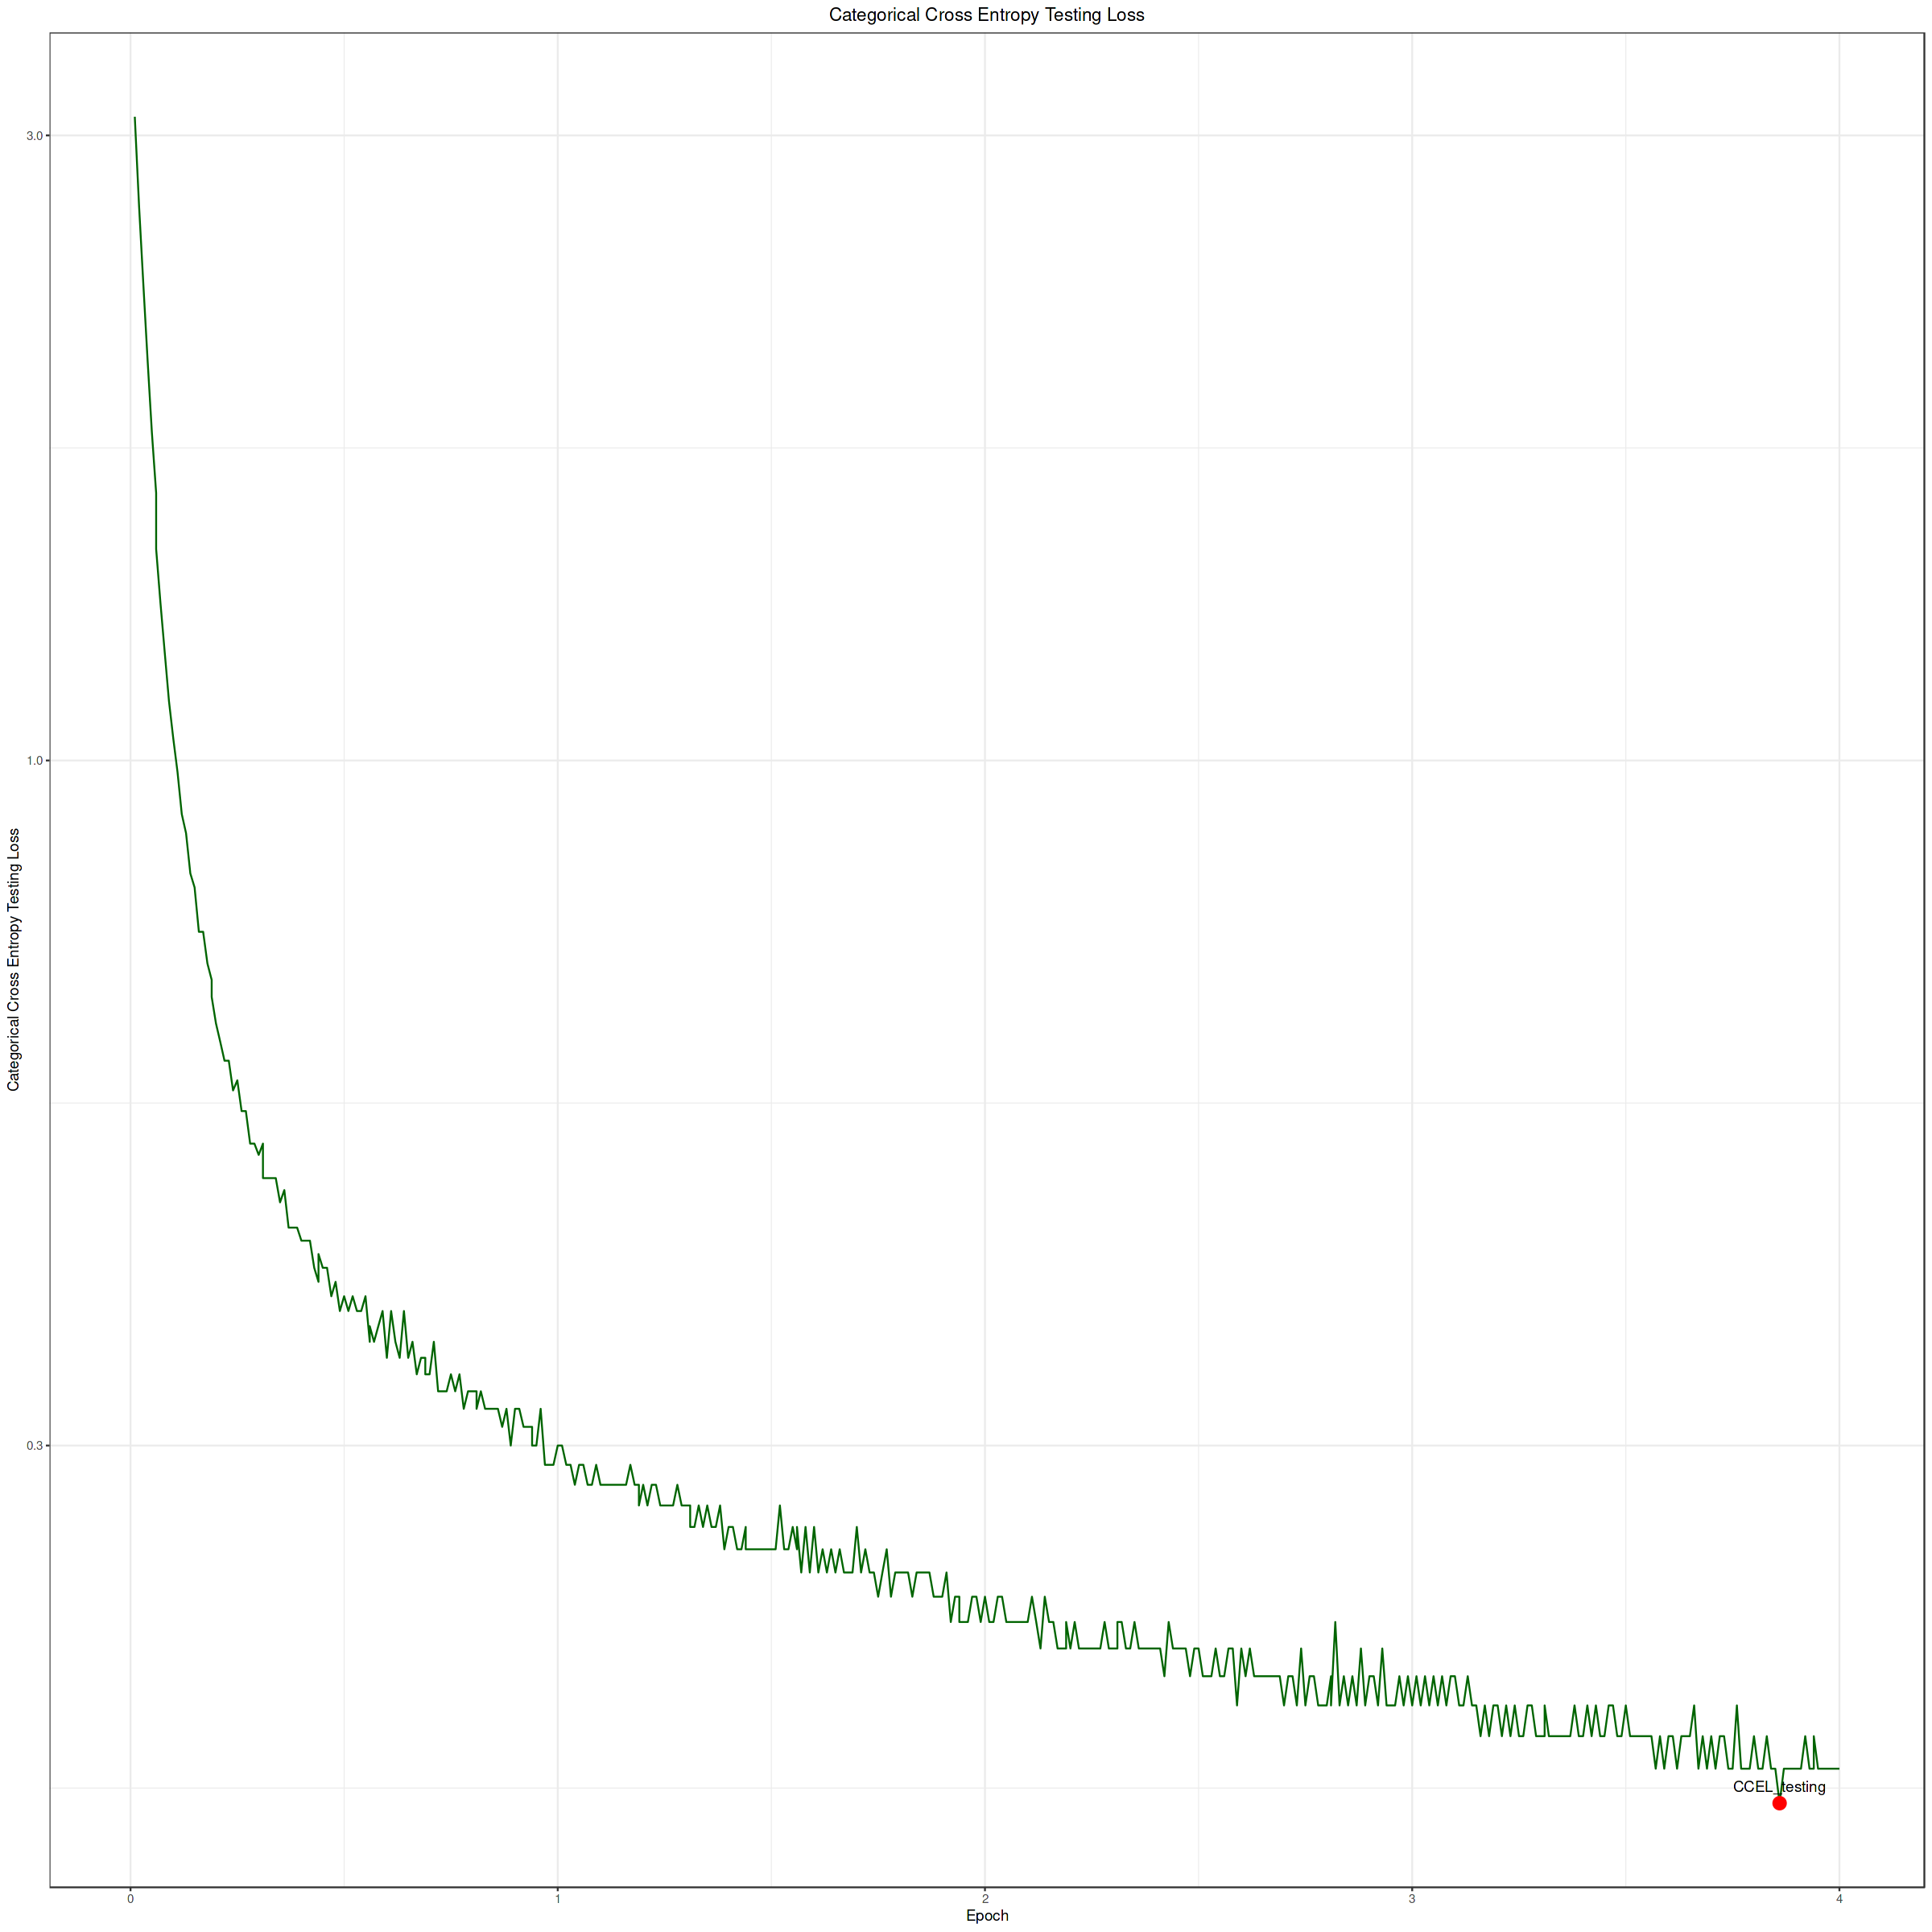

In [25]:
options(repr.plot.width = 20, repr.plot.height = 20)
print(CCEntropy_Loss_CCEL_testing_x_out)

### Plot Categorical Cross Entropy Training Loss
Plot of the mean categorical cross entropy TRAINING loss for CCEL_x3 for<br>
each epoch in log scale. The red point "CCEL_training" is the location of<br>
the training loss where the testing loss is the lowest.<br>

In [26]:
CCEntropy_Loss_CCEL_x_out <- ggplot(data = CCEntropy_Loss, aes(x = epoch, y = CCEL_x_out)) +
  geom_line(color = "darkgreen") +
  geom_point(data = subset(CCEntropy_Loss, epoch == Epoch_lowest_CCEntropy_Loss), aes(x = epoch, y = CCEL_x_out), color = "red", size = 4) +
  geom_text(data = subset(CCEntropy_Loss, epoch == Epoch_lowest_CCEntropy_Loss), aes(x = epoch, y = CCEL_x_out, label = "CCEL_training"), vjust = -1) +
  scale_y_log10() +
  labs(x = "Epoch", y = "Categorical Cross Entropy Training Loss", title = "Categorical Cross Entropy Training Loss") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

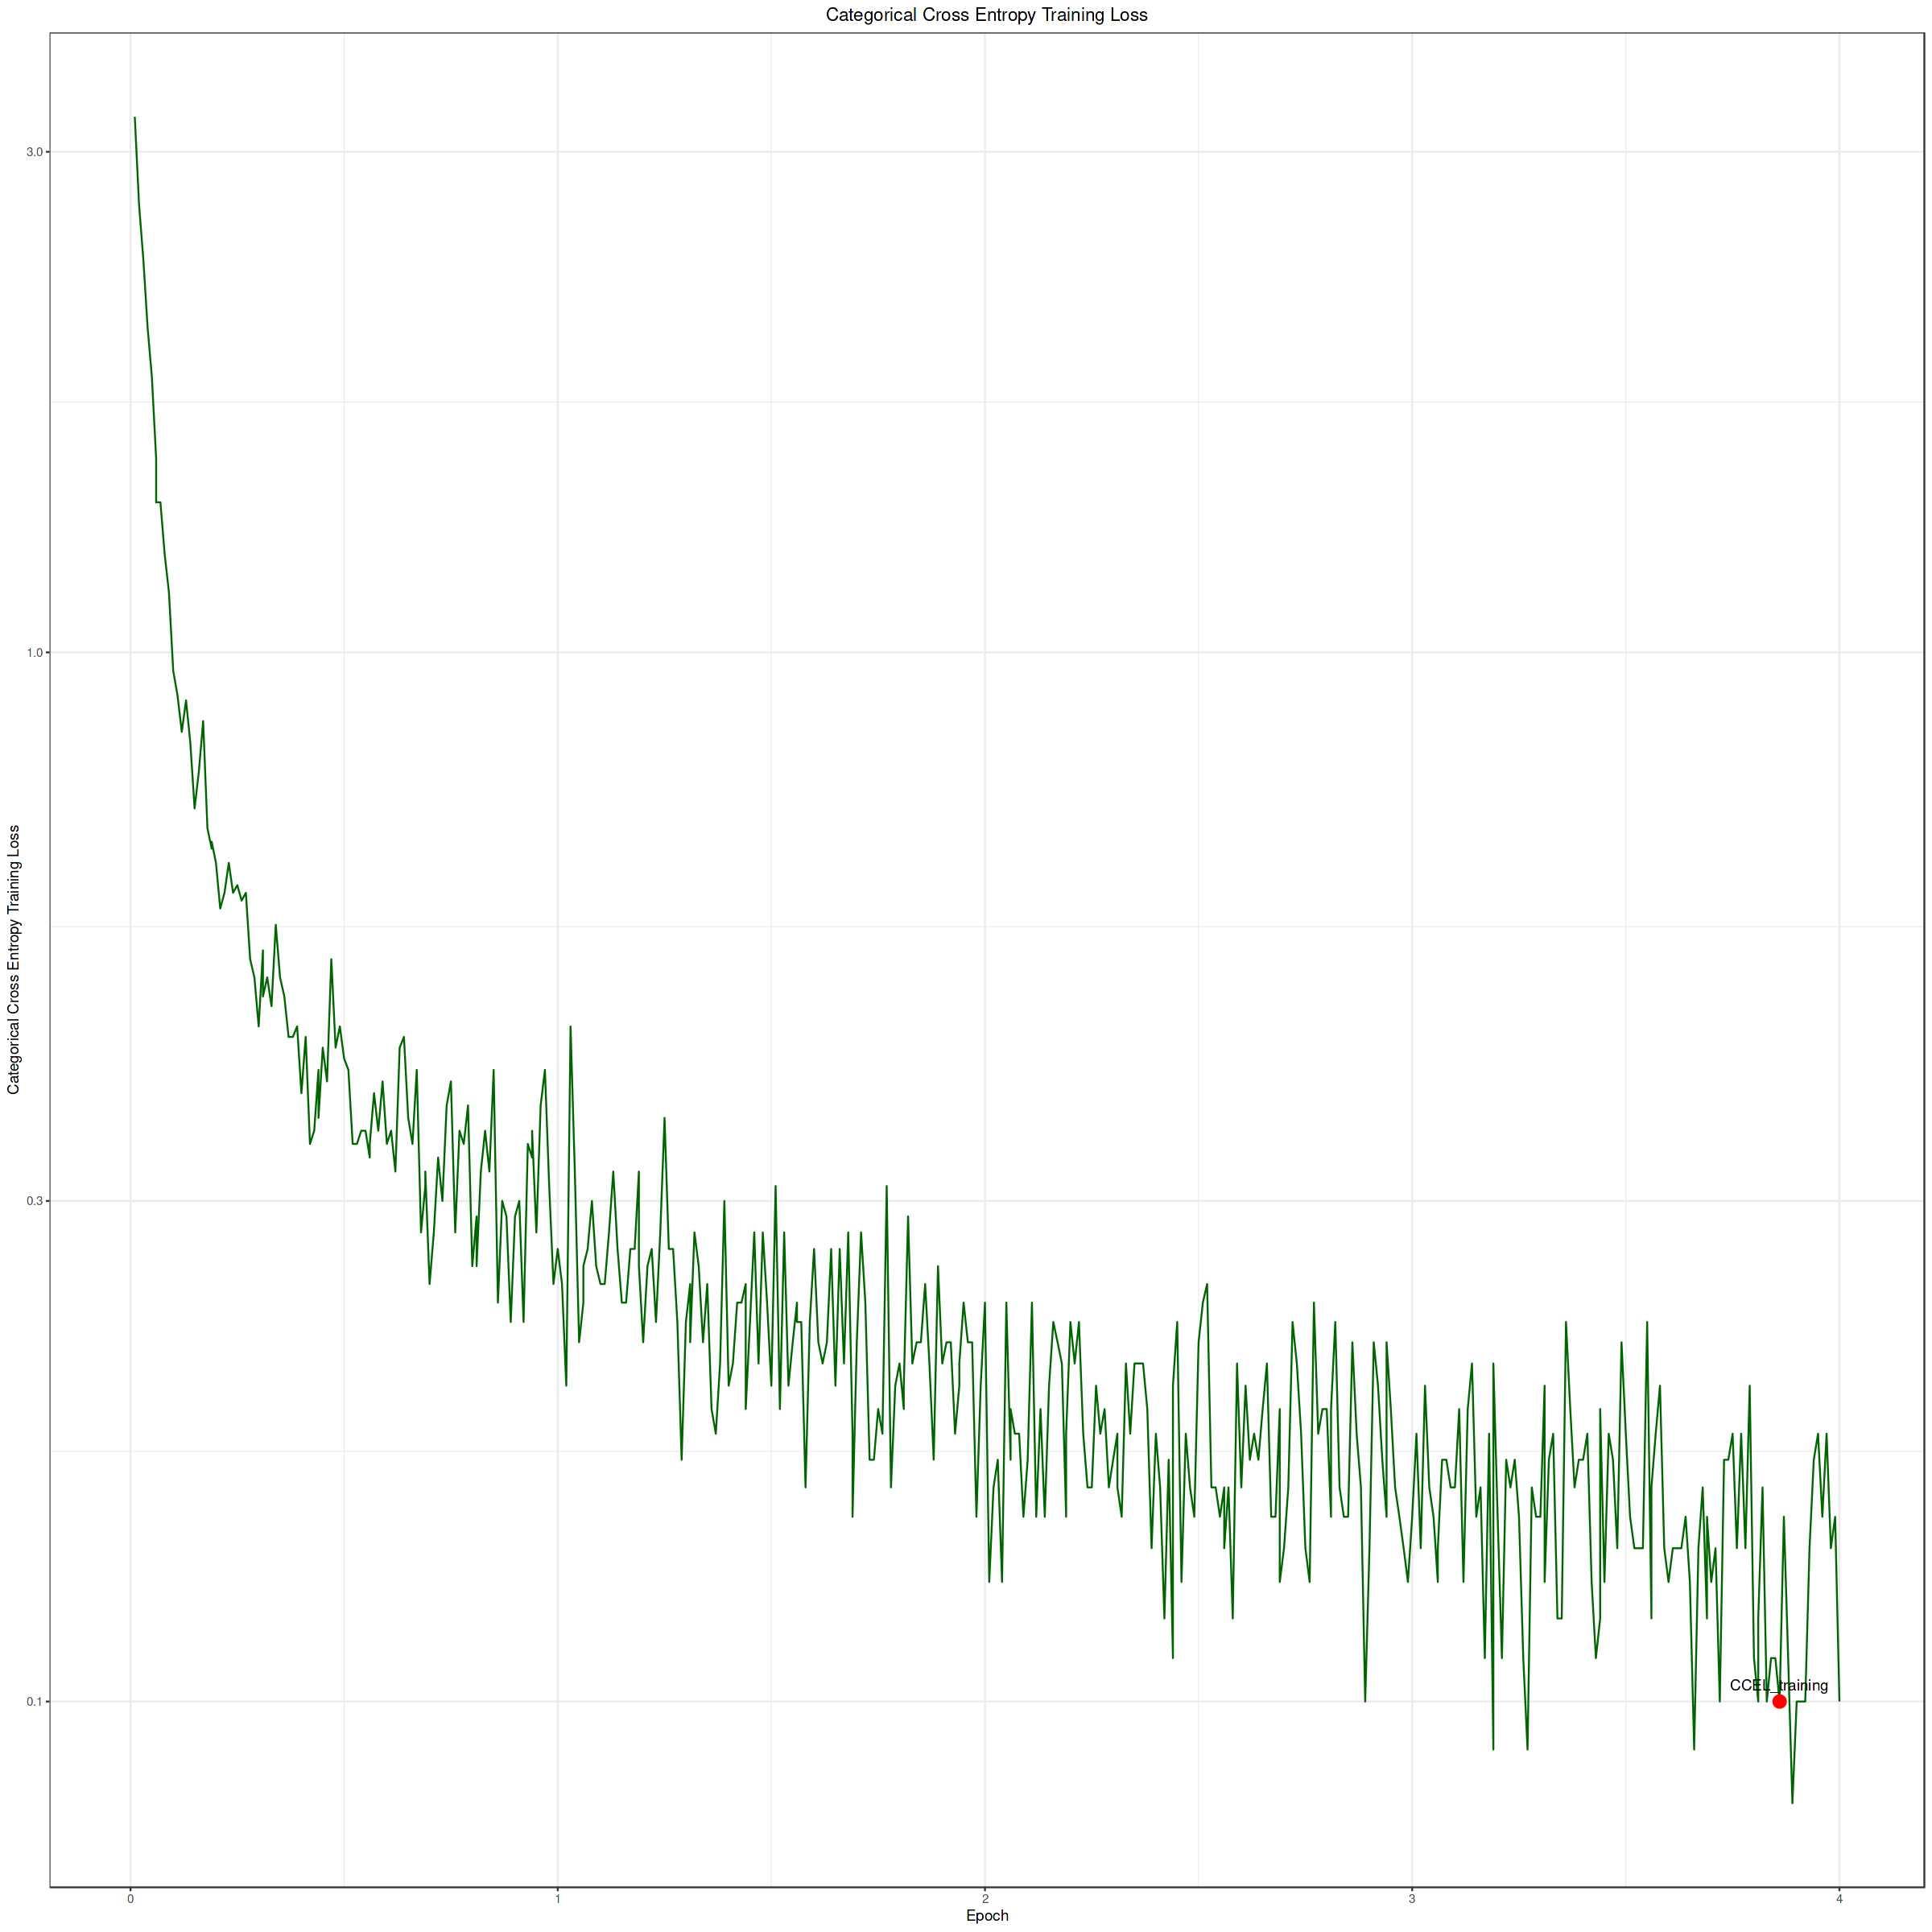

In [27]:
options(repr.plot.width = 20, repr.plot.height = 20)
print(CCEntropy_Loss_CCEL_x_out)

### Plot Tracking Model Performance: Training vs Testing Accuracy
Percent Accuracy Derived from Lowest Loss in Testing Data.<br>

In [28]:

if (n < N_training) {
#######################
# SGD and Mini Batch Gradient Descent
#######################
Optimal_Training_Accuracy <-Accuracy_Percent$Training_percent[Iteration_lowest_CCEntropy_Loss]
Optimal_Testing_Accuracy <-Accuracy_Percent$Testing_percent[Iteration_lowest_CCEntropy_Loss]

} else {
#######################
#Batch Gradient Descent
#######################
Optimal_Training_Accuracy <-Accuracy_Percent$Training_percent[Epoch_lowest_CCEntropy_Loss]
Optimal_Testing_Accuracy <-Accuracy_Percent$Testing_percent[Epoch_lowest_CCEntropy_Loss]
}

Black dot is the accuracy that corresponds to the lowest loss in the<br>
testing data.<br>

In [29]:
if (n < N_training) {
  # SGD and Mini Batch Gradient Descent
  Percent_Accuracy_Plot <- ggplot(Accuracy_Percent, aes(x = seq_len(nrow(Accuracy_Percent)))) +
      geom_line(aes(y = Testing_percent, color = "Testing Accuracy")) +
      geom_point(aes(x = Iteration_lowest_CCEntropy_Loss, y = Optimal_Testing_Accuracy), color = "black", size = 5) +
      geom_text(aes(x = Iteration_lowest_CCEntropy_Loss - 3, y = Optimal_Testing_Accuracy, label = "Optimal Testing Accuracy"), vjust = -1.5) +
      geom_text(aes(x = Iteration_lowest_CCEntropy_Loss, y = Optimal_Testing_Accuracy, label = as.character(Optimal_Testing_Accuracy)), vjust = 2.5)+
      labs(x = "Iteration", y = "Accuracy %", 
        title = "Testing Accuracy Over Iterations",
        color = "Accuracy Type") +
      theme_minimal() +
      scale_color_manual(values = c("blue", "black"), 
             labels = c("Testing Accuracy", "Optimal Accuracy")) +
      scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 2.5))

} else {
  # Batch Gradient Descent
  Percent_Accuracy_Plot <- ggplot(Accuracy_Percent, aes(x = seq_len(nrow(Accuracy_Percent)))) +
    geom_line(aes(y = Testing_percent, color = "Testing Accuracy")) +
    geom_point(aes(x = Epoch_lowest_CCEntropy_Loss, y = Optimal_Testing_Accuracy), color = "black", size = 5) +
    geom_text(aes(x = Epoch_lowest_CCEntropy_Loss - 3, y = Optimal_Testing_Accuracy, label = "Optimal Testing Accuracy"), vjust = -1.5) +
    geom_text(aes(x = Epoch_lowest_CCEntropy_Loss, y = Optimal_Testing_Accuracy, label = as.character(Optimal_Testing_Accuracy)), vjust = 2.5)+
    labs(x = "Epoch", y = "Accuracy %", 
         title = "Testing Accuracy Over Epochs",
         color = "Accuracy Type") +
    theme_minimal() +
    scale_color_manual(values = c("blue", "black"), 
                       labels = c("Testing Accuracy", "Optimal Accuracy")) +
    scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 2.5))
}

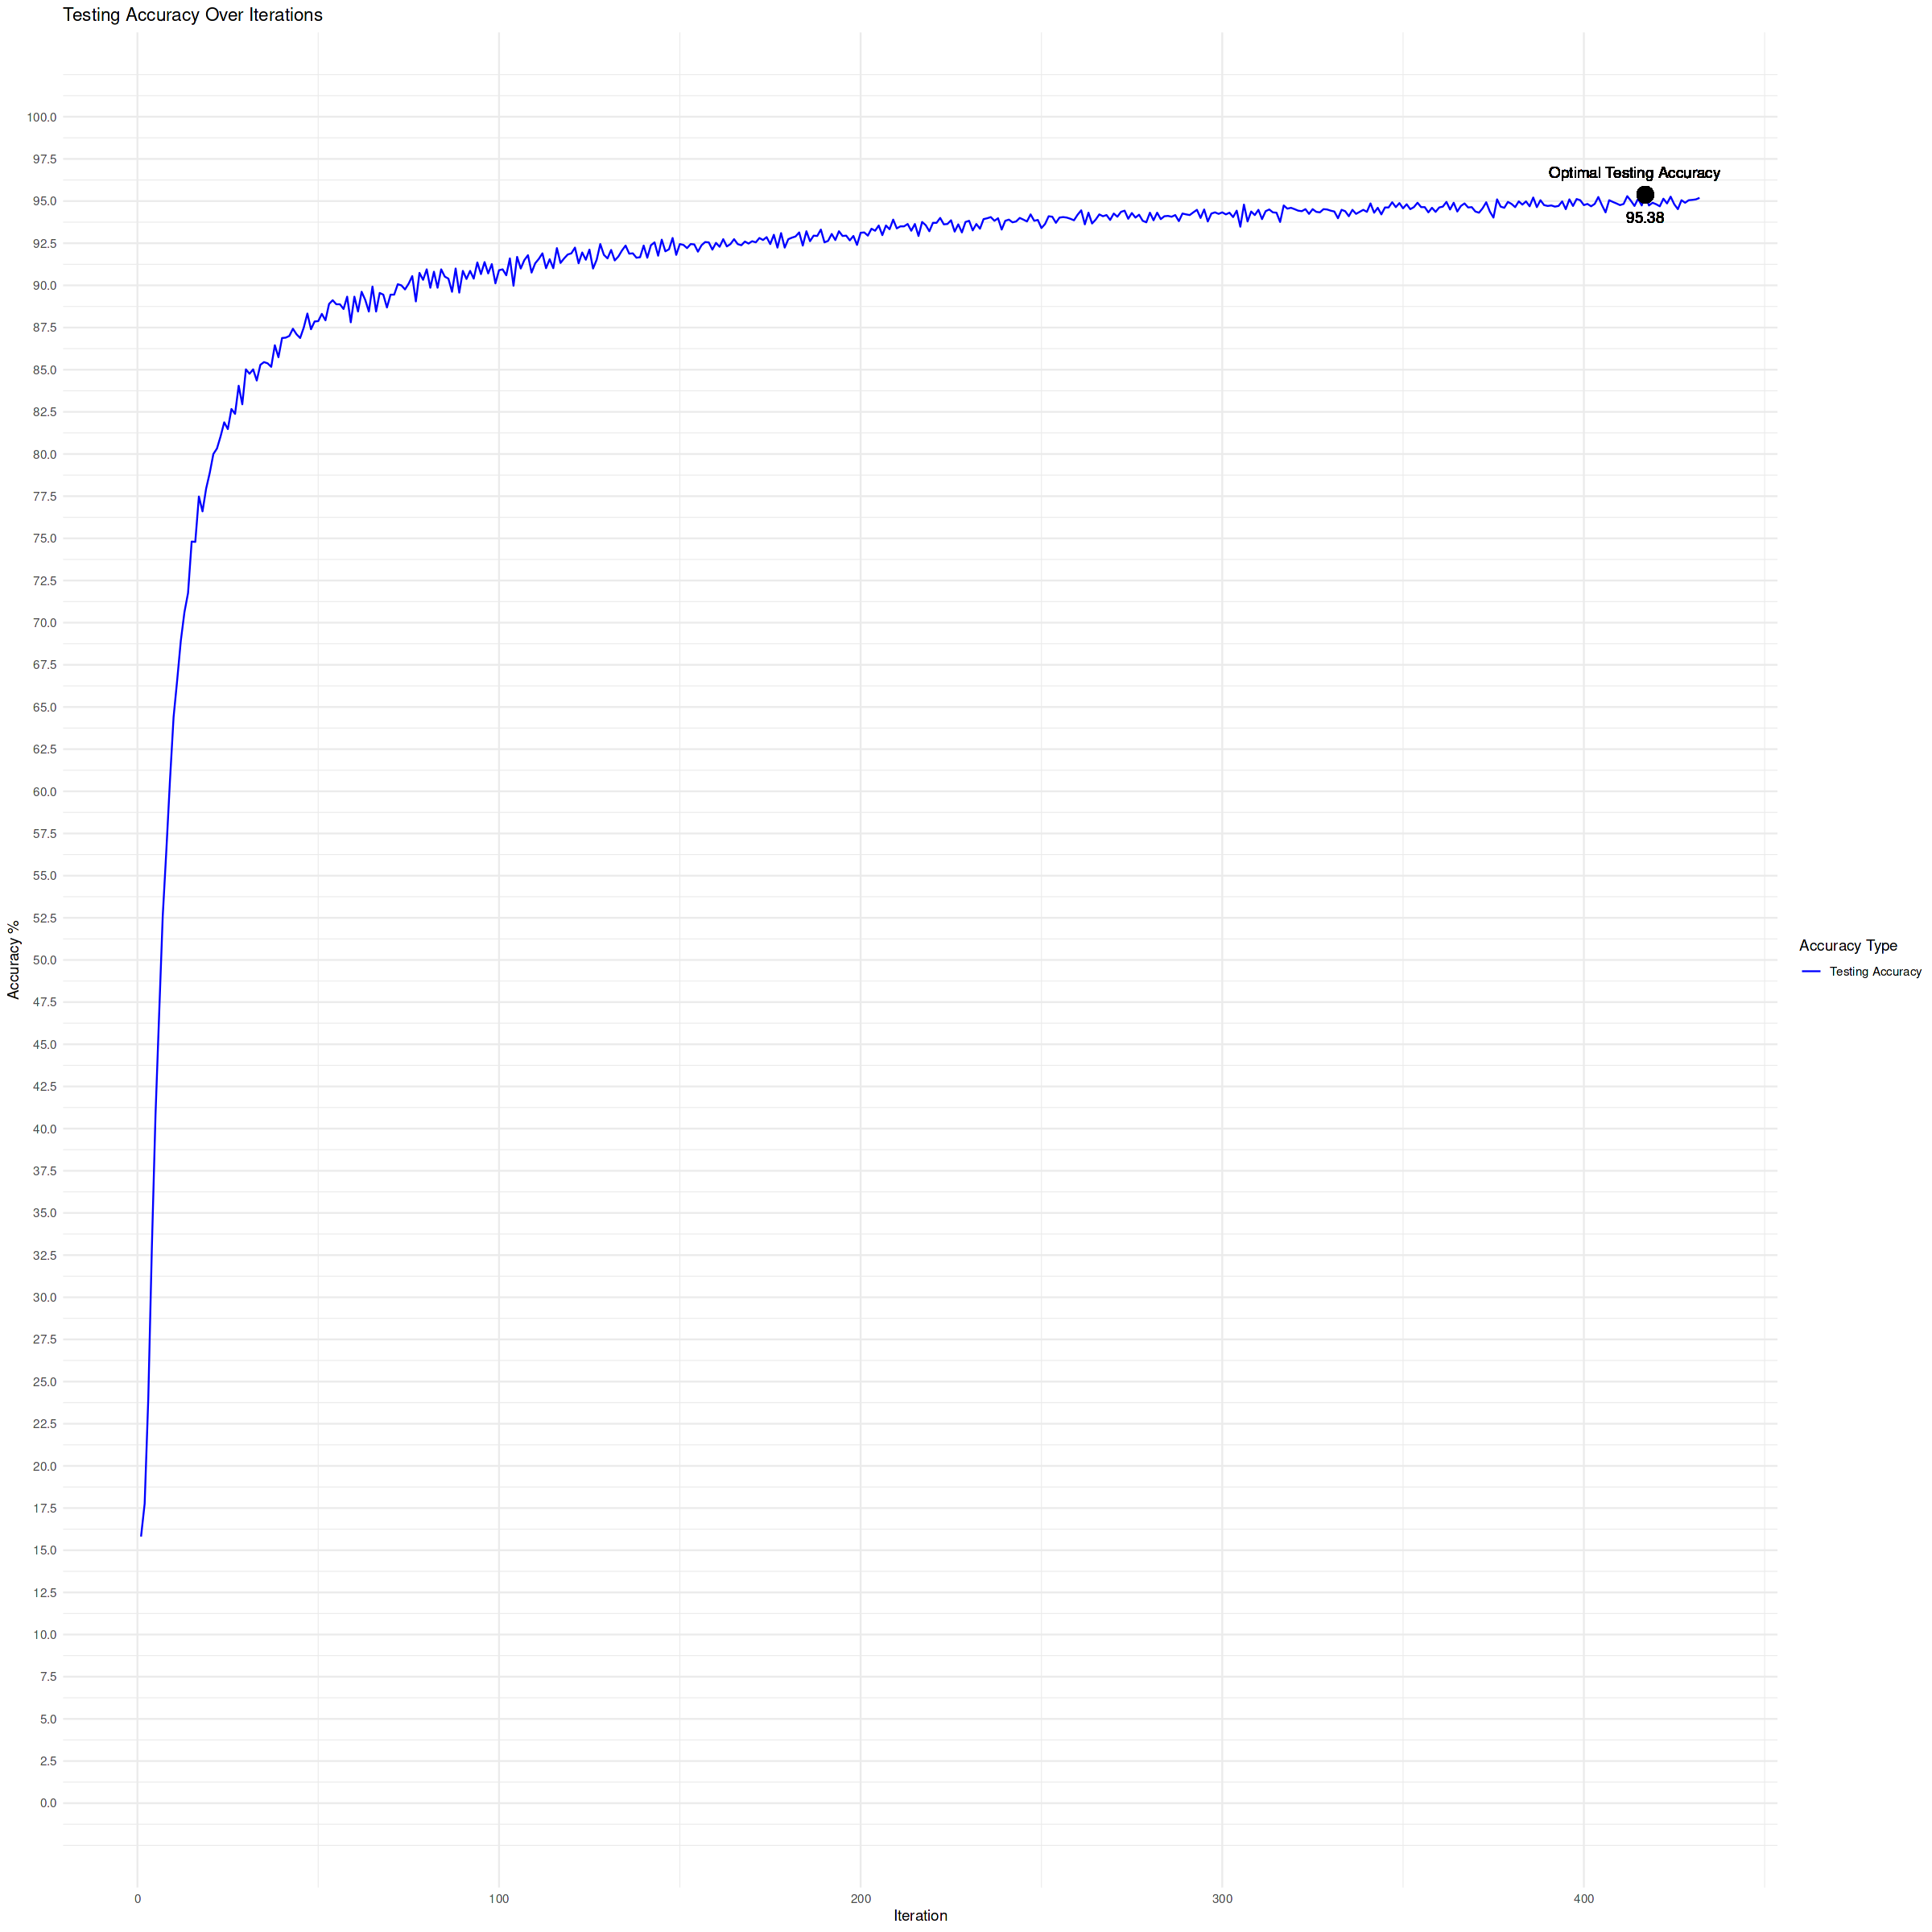

In [30]:
options(repr.plot.width = 20, repr.plot.height = 20)
print(Percent_Accuracy_Plot)

## Neural Network Performance Summary
### No Mapping vs Mapping

In [31]:
# No mapping vs Fourier Feature Mapping
switch(NoMapping_vs_FourierFeatureMapping,
       "No mapping" = {
print(paste("No mapping"))
       },
       "Feature Mapping" = {
print(paste("Fourier Feature Mapping"))
       })  

[1] "No mapping"


### Neural Network Parameters

In [32]:
if (n < N_training) {
#SGD and Mini Batch Gradient Descent
print(paste("Number of training observations used in each batch:",n))
} else {
#Batch Gradient Descent
print(paste("Number of training observations used in each batch:","All observations"))
} 

print(paste("Number of hidden layers:",num_hidden_layers)) 

if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
print(paste("Number of neurons in hidden layer:",nu))
} else {
###############
# When using Two Hidden Layers
###############
print(paste("Number of neurons in hidden layer 1:",nu))
print(paste("Number of neurons in hidden layer 2:",nu2))
} 

[1] "Number of training observations used in each batch: 350"
[1] "Number of hidden layers: 1"
[1] "Number of neurons in hidden layer: 100"


### Epoch with Min Testing CCE Loss

In [33]:
print(paste("Epoch with Minimum Testing CCE Loss:", Epoch_lowest_CCEntropy_Loss))

[1] "Epoch with Minimum Testing CCE Loss: 3.86"


### Categorical Cross Entropy Loss

In [34]:
print(paste("Minimum Testing CCE Loss:", Min_CCEntropy_Loss))
print(paste("Training CCE Loss based on lowest testing CCE Loss:", Min_CCEntropy_Loss_training)) 

[1] "Minimum Testing CCE Loss: 0.16"
[1] "Training CCE Loss based on lowest testing CCE Loss: 0.1"


### Optimal Accuracy

In [35]:
print(paste("Optimal Testing Accuracy %:", Optimal_Testing_Accuracy)) 

[1] "Optimal Testing Accuracy %: 95.38"


## Feedforward Prediction
### Optimal M Weight Matrices

In [36]:
###########################
# Optimal M Weight Matrices
###########################
if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
if (n < N_training) {
#SGD and Mini Batch Gradient Descent
M1_min <-M1_list[[Iteration_lowest_CCEntropy_Loss]]

M2_min <-M2_list[[Iteration_lowest_CCEntropy_Loss]]
} else {
#Batch Gradient Descent
M1_min <-M1_list[[Epoch_lowest_CCEntropy_Loss]]

M2_min <-M2_list[[Epoch_lowest_CCEntropy_Loss]]
}

} else {
###############
# When using Two Hidden Layers
###############
if (n < N_training) {
#SGD and Mini Batch Gradient Descent
M1_min <-M1_list[[Iteration_lowest_CCEntropy_Loss]]

M2_min <-M2_list[[Iteration_lowest_CCEntropy_Loss]]

M3_min <-M3_list[[Iteration_lowest_CCEntropy_Loss]]
} else {
#Batch Gradient Descent
M1_min <-M1_list[[Epoch_lowest_CCEntropy_Loss]]

M2_min <-M2_list[[Epoch_lowest_CCEntropy_Loss]]

M3_min <-M3_list[[Epoch_lowest_CCEntropy_Loss]]
}

}

### Feedforward Code

In [37]:
# Randomly select 3 images from the testing data
Randomly_selected_rows_pred <-sample(nrow(Data_testing_scaled), n_prediction, replace = FALSE)

Data_pred <-Data_testing_scaled[Randomly_selected_rows_pred, ] 

Row_Image_Matrix_pred <-Data_pred[, 2:ncol(Data_pred)]  %>%  as.matrix()
  ###############################################
  # Code for Training forward forward pass
  ###############################################
#########################
# No mapping vs Fourier Feature Mapping
switch(NoMapping_vs_FourierFeatureMapping,
       "No mapping" = {
X1_pred <-Row_Image_Matrix_pred %>% t()

X1_map_vs_no_map_pred <-X1_pred
       },
       "Feature Mapping" = {
#Xi = X1_pred
           
X1_pred <-Row_Image_Matrix_pred %>% t()

Hf_pi_B_Xi_pred <-Hf_pi_B_pred * X1_pred

# apply the cos to each element of the matrix
cos_element_wise_pred <-cos(Hf_pi_B_Xi_pred)

# apply the sin to each element of the matrix
sin_element_wise_pred <-sin(Hf_pi_B_Xi_pred)

###############################################
# Create a vector of alternating ones and zeros
one_zero_V_pred <- t(rep(c(1, 0), length.out = Xd_m_rows))  %>% as.matrix() 

# Repeat and bind the vector into a matrix
one_zero_M_pred <- matrix(rep(one_zero_V_pred, n_prediction,), nrow = Xd_m_rows, ncol = n_prediction, byrow = FALSE)  

cos_matrix_pred <-one_zero_M_pred * cos_element_wise_pred

# Create a vector of alternating zeros and ones
zero_one_V_pred <- t(rep(c(0, 1), length.out = Xd_m_rows))  %>% as.matrix()

# Repeat and bind the vector into a matrix
zero_one_M_pred <- matrix(rep(zero_one_V_pred, n_prediction,), nrow = Xd_m_rows, ncol = n_prediction, byrow = FALSE)

sin_matrix_pred <-zero_one_M_pred * sin_element_wise_pred

# Fourier Feature Mapping
gamma_Xi_pred <- cos_matrix_pred + sin_matrix_pred

X1_map_vs_no_map_pred <-gamma_Xi_pred
       })
#########################
X1_pred <-rbind(X1_map_vs_no_map_pred, rep(1, ncol(X1_map_vs_no_map_pred)))

Z2_pred <- M1_min %*% X1_pred

LeakyReLU_pred <- t(apply(Z2_pred, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
    as.matrix()

X2_pred <- rbind(LeakyReLU_pred, 1) %>% 
  as.matrix()
###############################################
# For one and two hidden layers
if (num_hidden_layers < 2) {
###############
# When using One Hidden Layer
###############
Z_out_pred <- M2_min %*% X2_pred

} else {
###############
# When using Two Hidden Layers
###############
Z3_pred <- M2_min %*% X2_pred

LeakyReLU2_pred <- t(apply(Z3_pred, 1, function(x) ifelse(x >= 0, x, LeakyReLU_alpha * x))) %>% 
    as.matrix()

X3_pred <- rbind(LeakyReLU2_pred, 1) %>% 
  as.matrix()

Z_out_pred <- M3_min %*% X3_pred
}

X_out_pred <-apply(Z_out_pred, 2, softmax_MAX)

# Predicted Minist Digit
Mnist_digit_pred <-apply(X_out_pred, 2, which.max)-1

### Pick 3 Random Images From Testing Data to Predict.

In [38]:
# Each row vector in Row_Image_Matrix_pred is a 784 pixel image. sqrt(784) = 28
# Thus reshape each row vector into a 28 x 28 matrix
# Max pixel value comes from the max value in the original data 

# Define the show_digit function
show_digit <- function(arr784, col = gray.colors(max(arr784))) {
  image(matrix(arr784, nrow = 28)[, 28:1], col = col)
}

[1] "Predicted Number: 3"
[1] "Image:"


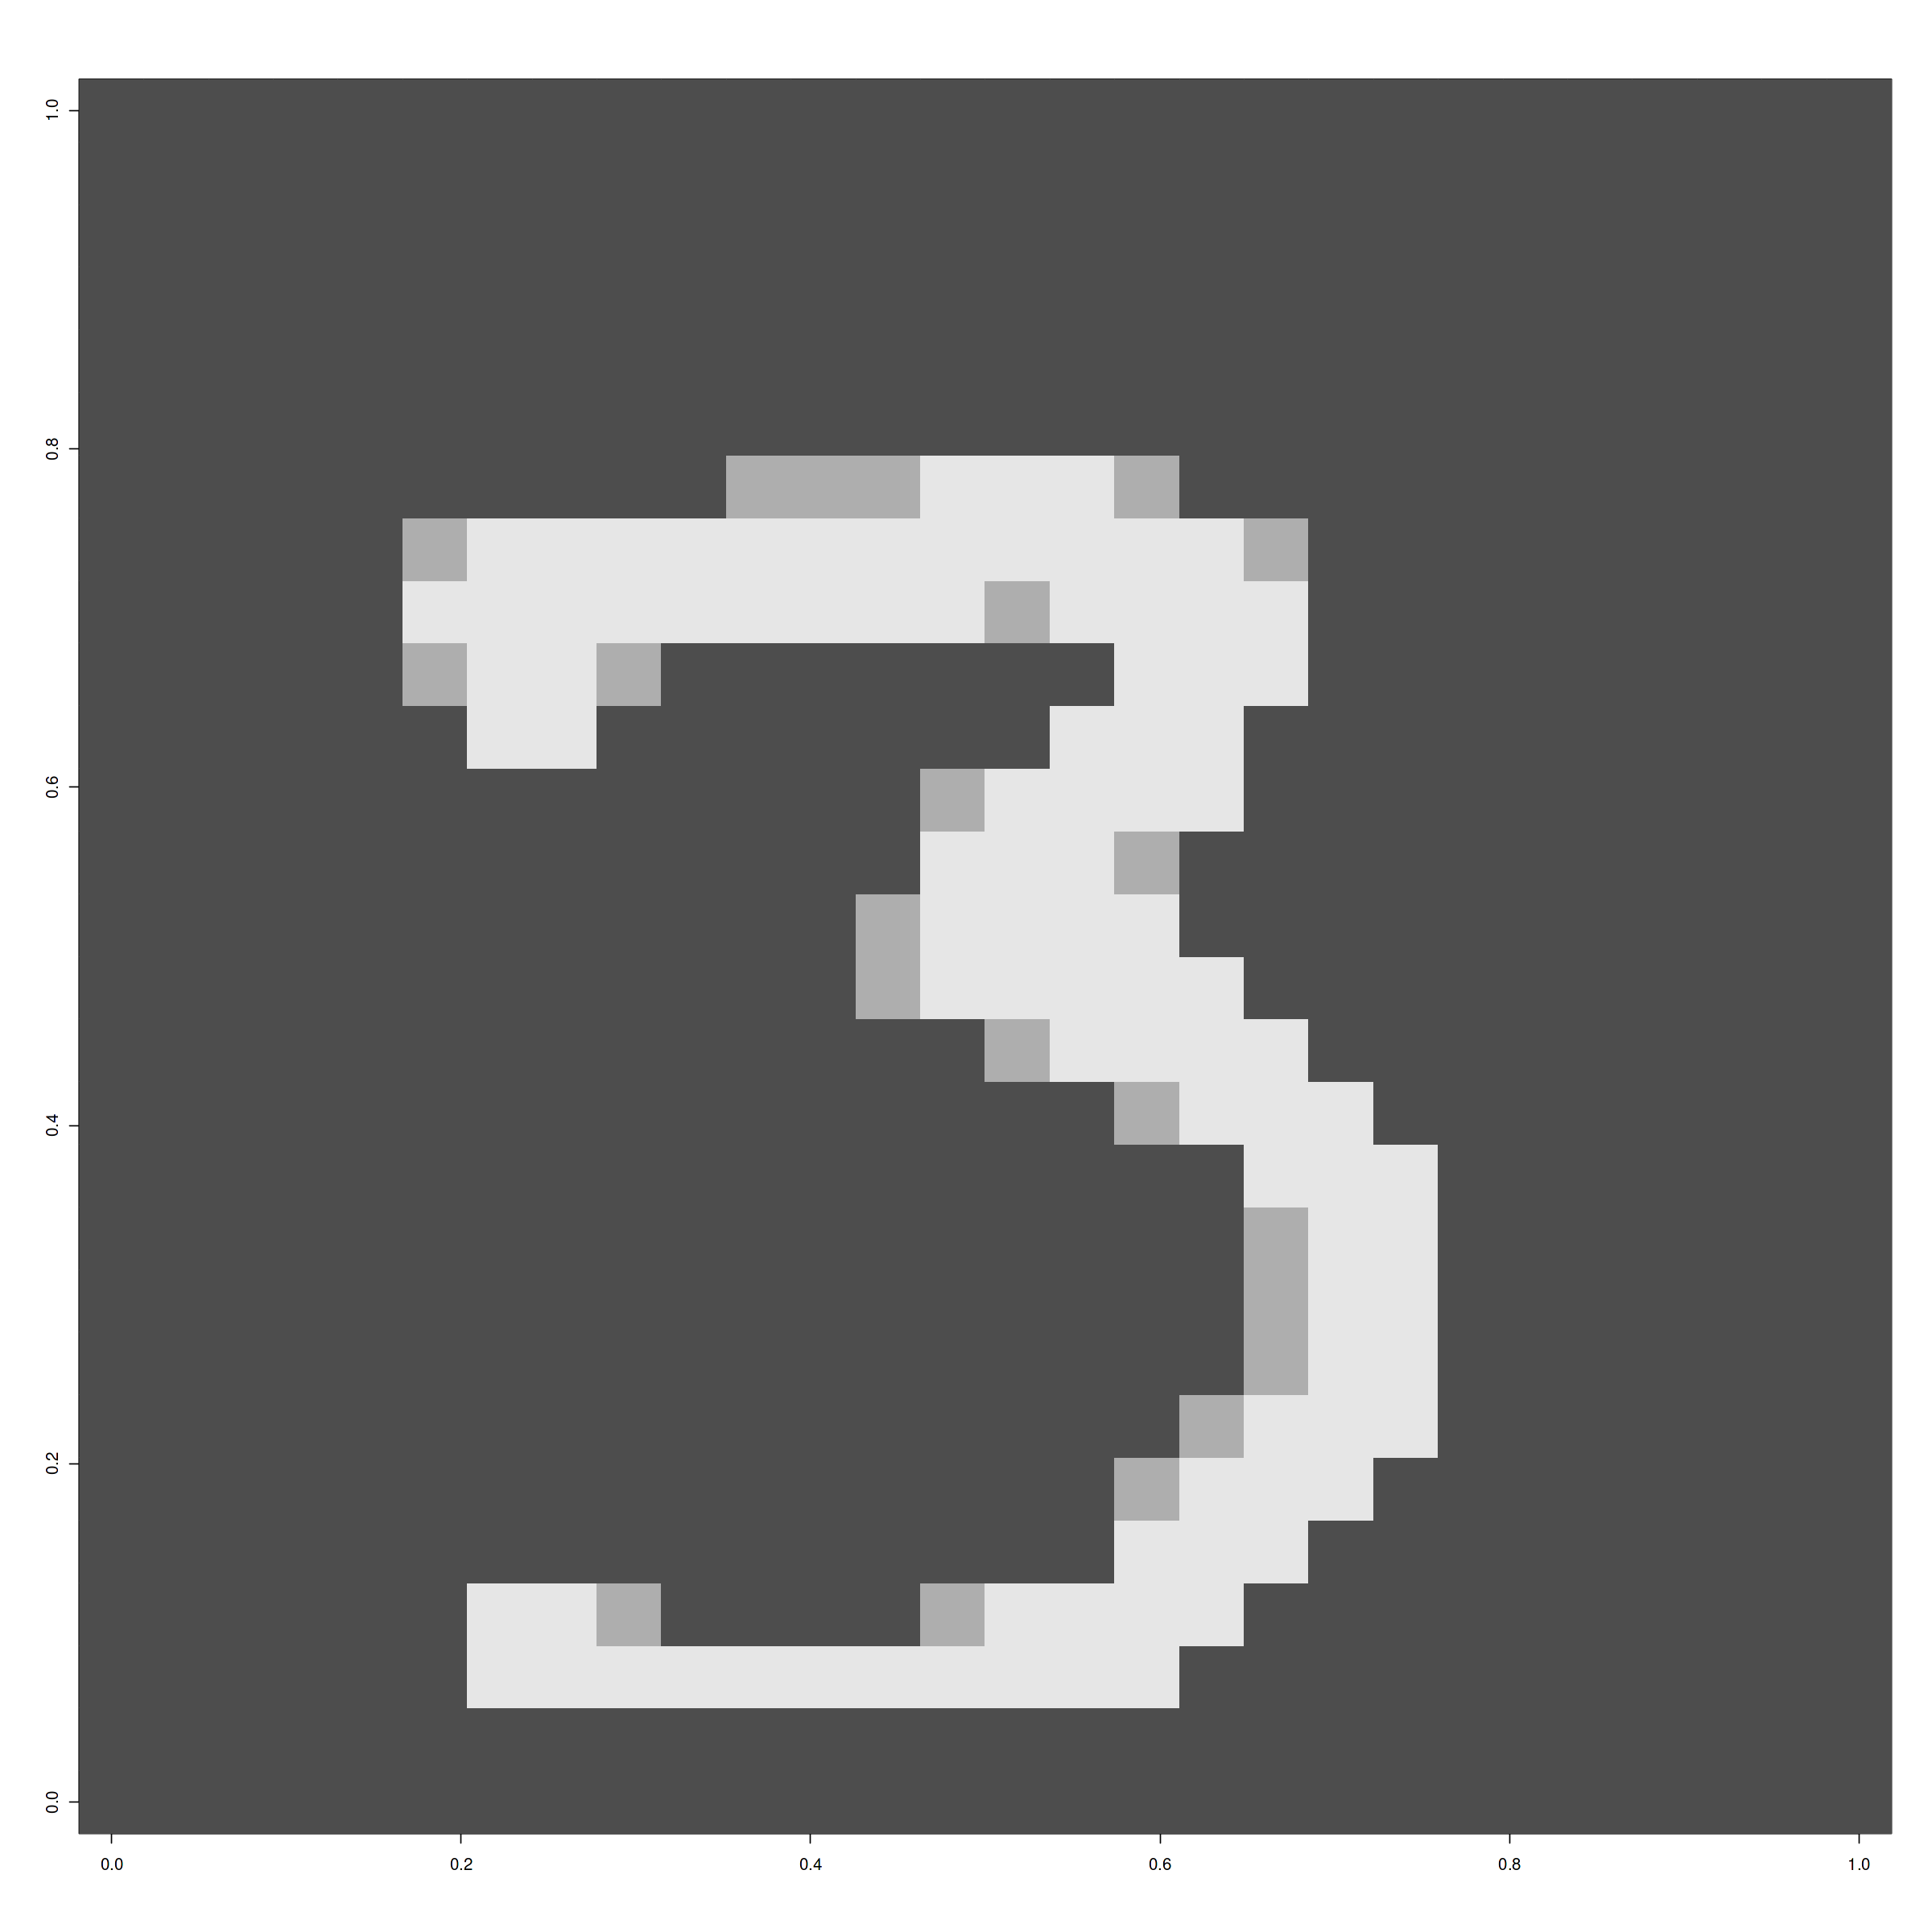

In [39]:
# Reshape the first row vector into a 28 x 28 matrix
first_digit_matrix <- Row_Image_Matrix_pred[1, ] %>% matrix(nrow = 28, ncol = 28, byrow = FALSE)

# Plot the first digit matrix and print the prediction
print(paste("Predicted Number:",Mnist_digit_pred[1]))
print(paste("Image:"))
show_digit(first_digit_matrix)

[1] "Predicted Number: 2"
[1] "Image:"


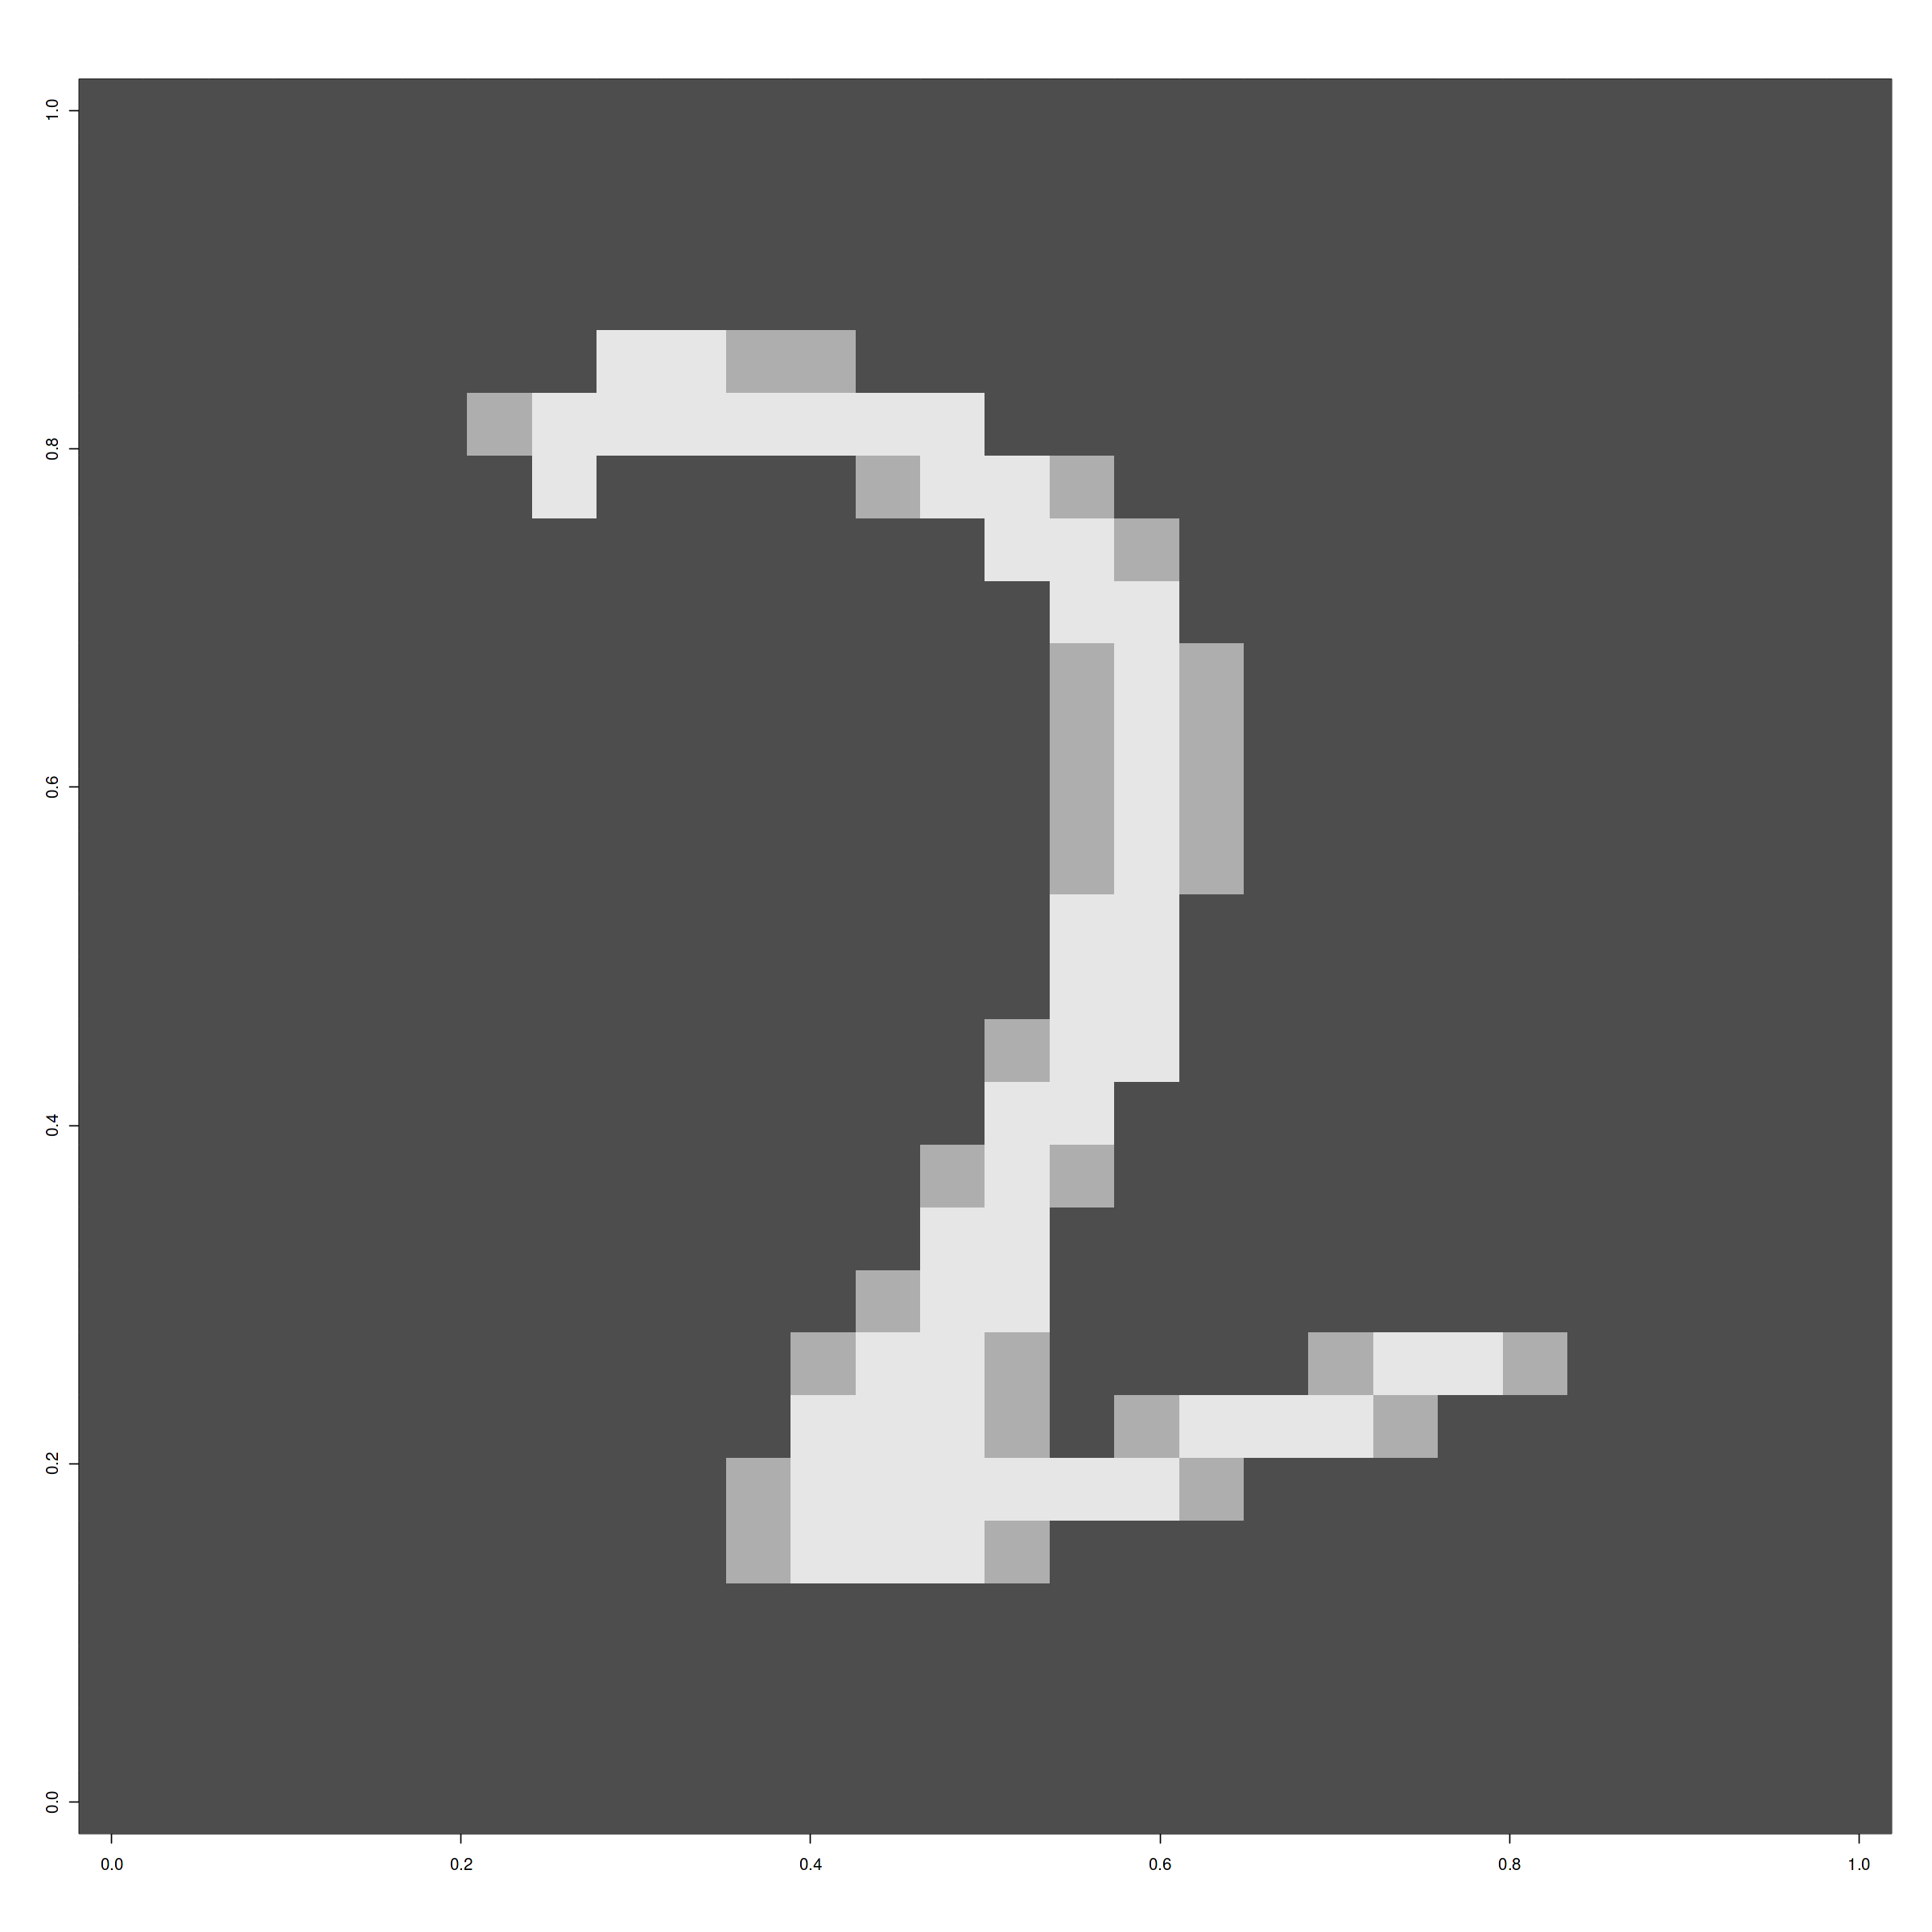

In [40]:
# Reshape the second row vector into a 28 x 28 matrix
second_digit_matrix <- Row_Image_Matrix_pred[2, ] %>% matrix(nrow = 28, ncol = 28, byrow = FALSE)

# Plot the second digit matrix and print the prediction
print(paste("Predicted Number:",Mnist_digit_pred[2]))
print(paste("Image:"))
show_digit(second_digit_matrix)

[1] "Predicted Number: 3"
[1] "Image:"


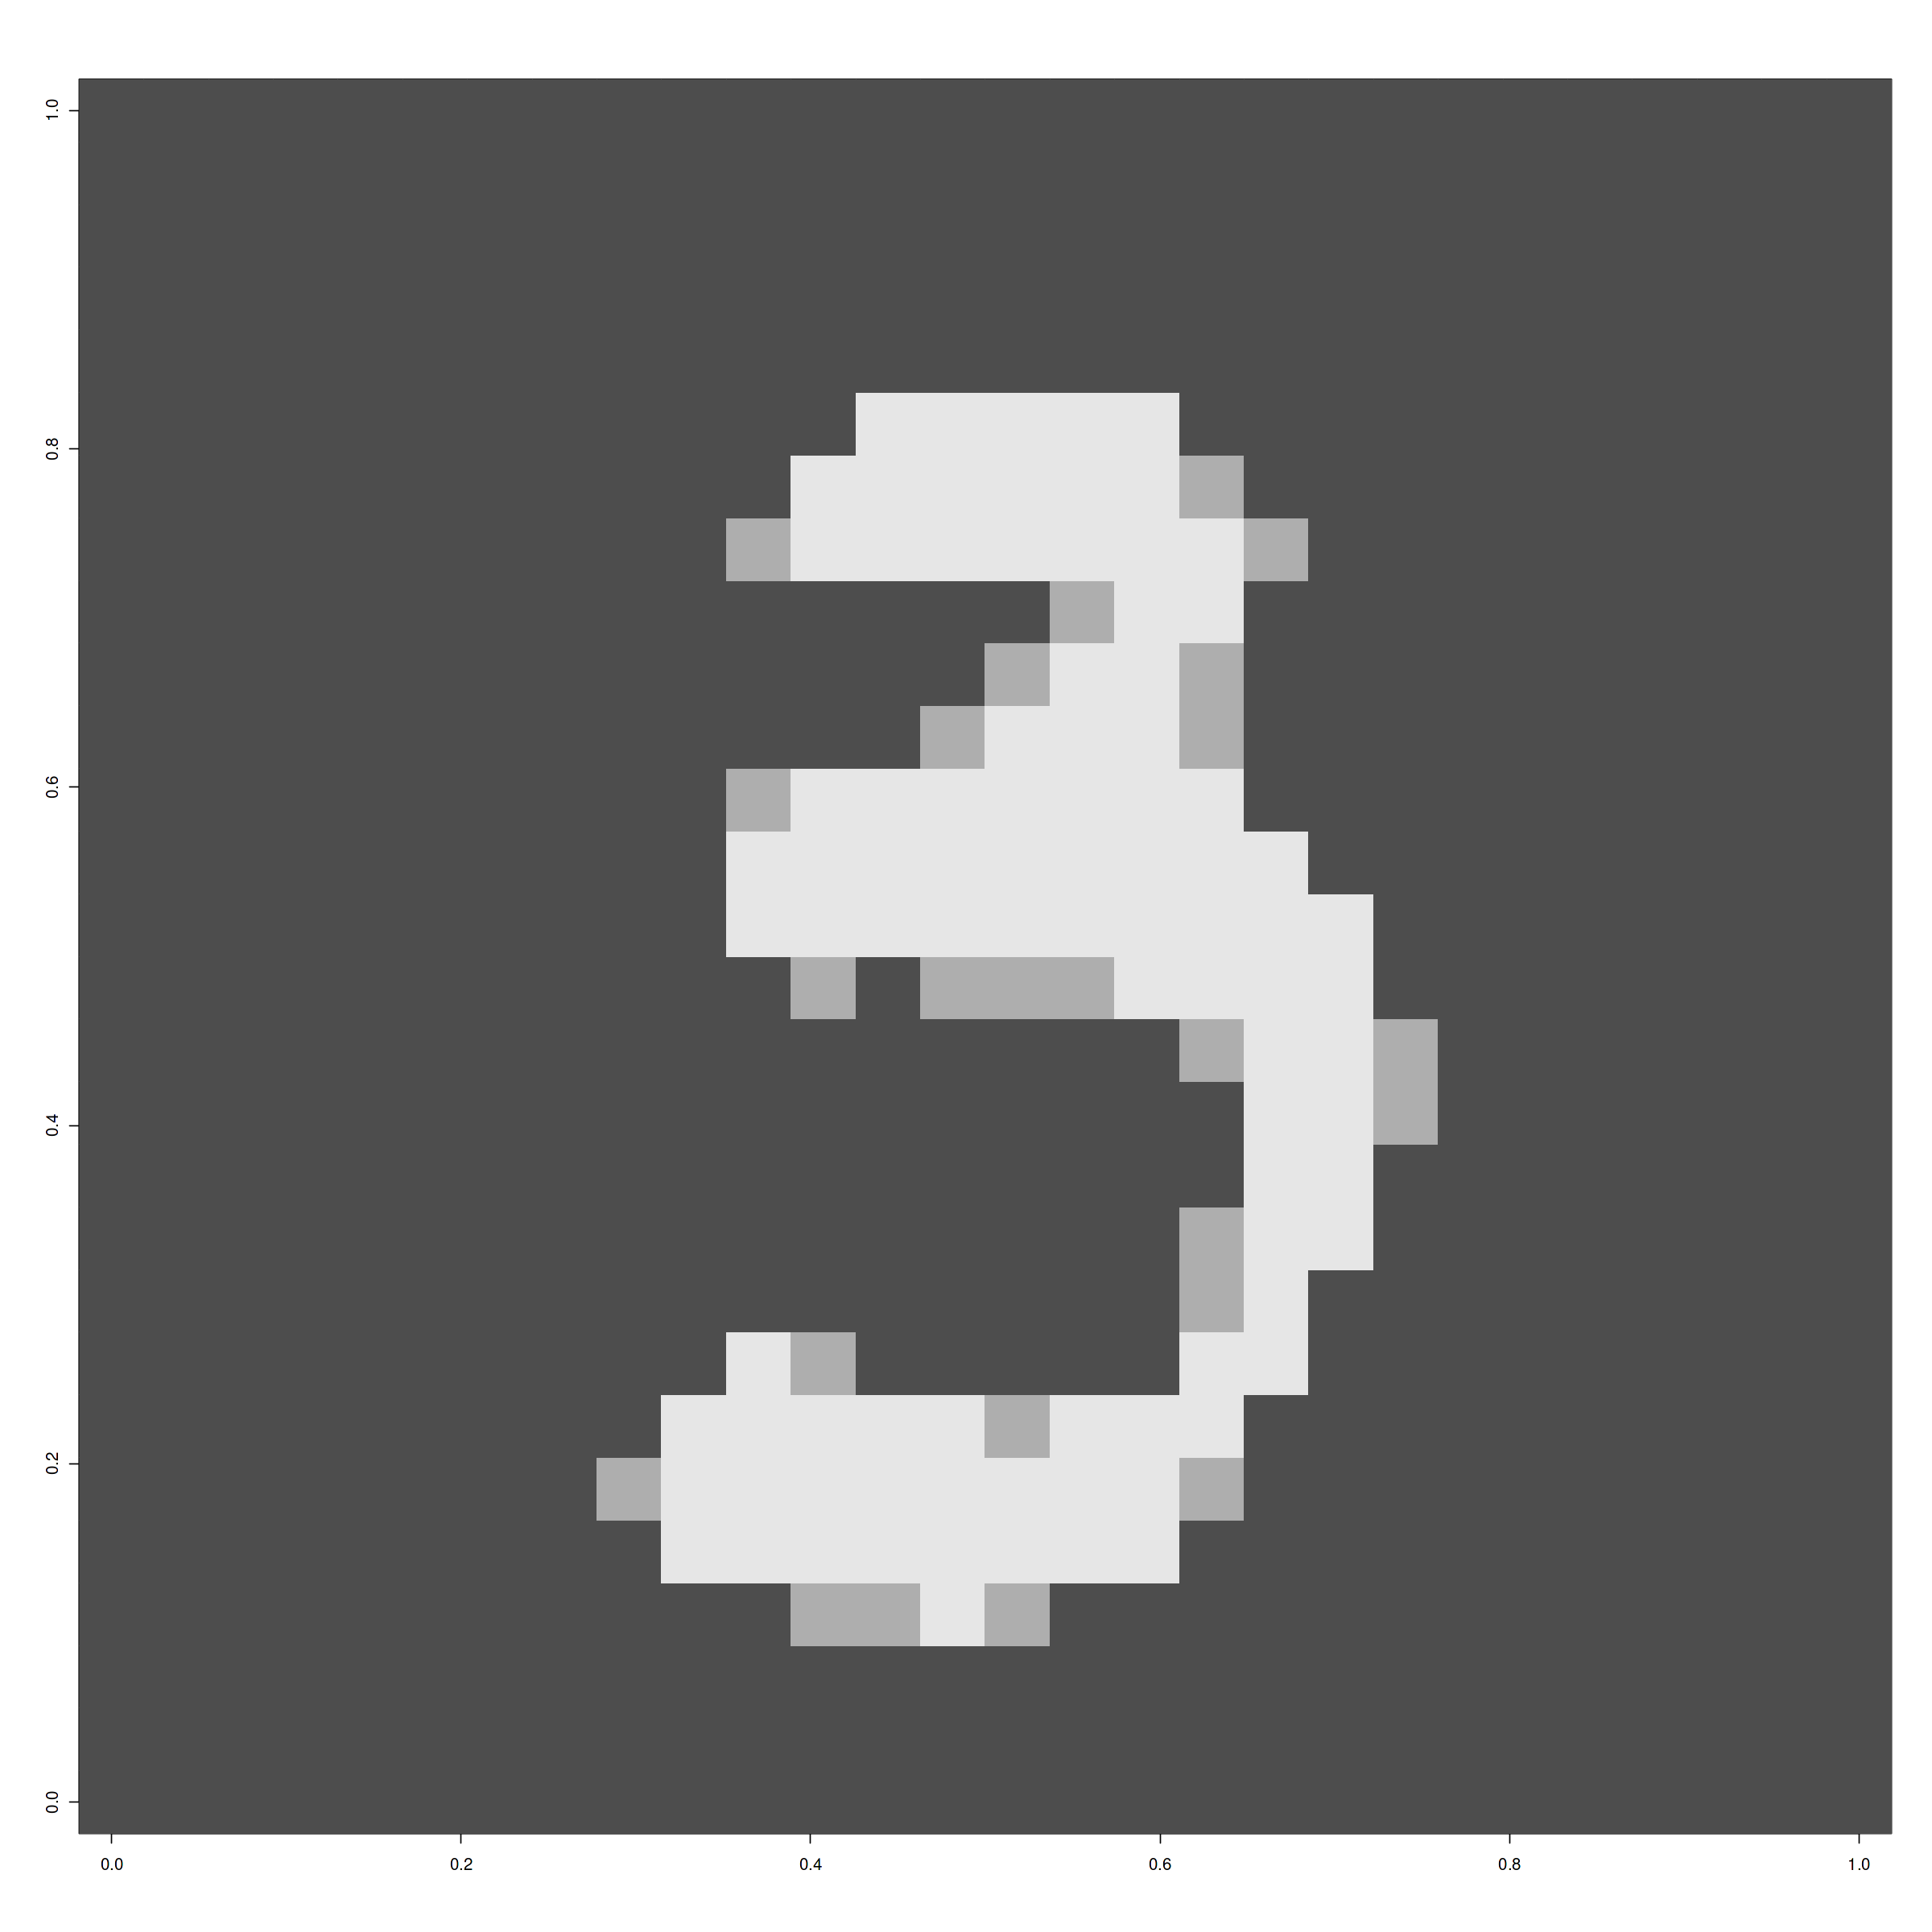

In [41]:
# Reshape the third row vector into a 28 x 28 matrix
third_digit_matrix <- Row_Image_Matrix_pred[3, ] %>% matrix(nrow = 28, ncol = 28, byrow = FALSE)

# Plot the third digit matrix and print the prediction
print(paste("Predicted Number:",Mnist_digit_pred[3]))
print(paste("Image:"))
show_digit(third_digit_matrix)

**FIN**

## References

B, U. (2021, November 15). Cost Function in Machine Learning. Medium.<br>
  https://medium.com/@uma.bollikonda/cost-function-in-machine-learning-129de85120d5<br>

@article{Chadha2020DistilledNeuralNetworks,<br>
  title   = {Neural Networks},<br>
  author  = {Chadha, Aman},<br>
  journal = {Distilled Notes for Stanford CS229: Machine Learning},<br>
  year    = {2020},<br>
  note    = {\url{https://aman.ai}}<br>
}<br>

charleshsliao. (2017, February 25). Two Ways of Visualization of MNIST with R. Charles’ Hodgepodge.<br>
https://charleshsliao.wordpress.com/2017/02/25/two-ways-of-visualization-of-mnist-with-r/<br>

Kingma, D., & Lei Ba, J. (2017). ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION.<br>
  https://arxiv.org/pdf/1412.6980.pdf<br>

LeCun, Y. (2009). MNIST handwritten digit database, Yann LeCun, Corinna Cortes and Chris Burges. Lecun.com.<br>
  http://yann.lecun.com/exdb/mnist/<br>

Mildenhall, B. (n.d.). Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains (10min talk)<br> 
  [Review of Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains (10min talk)].<br>
  https://www.youtube.com/watch?v=iKyIJ_EtSkw&ab_channel=BENMILDENHALL<br>

neuralthreads. (2021, December 6). Softmax function — It is frustrating that everyone talks about it but very few talk about its….<br> 
Medium. https://neuralthreads.medium.com/softmax-function-it-is-frustrating-that-everyone-talks-about-it-but-very-few-talk-about-its-54c90b9d0acd<br>

Sagar, A. (n.d.). 5 Techniques to Prevent Overfitting in Neural Networks<br>
  [Review of 5 Techniques to Prevent Overfitting in Neural Networks]. KDnuggets.<br> 
  https://www.kdnuggets.com/2019/12/5-techniques-prevent-overfitting-neural-networks.html<br>

Taboga, M. (n.d.). Vec operator [Review of Vec operator]. StatLect.<br>
  https://www.statlect.com/matrix-algebra/vec-operator<br>

Tancik, M., Srinivasan, P. P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U.,<br>
  Ramamoorthi, R., Barron, J. T., &amp; Ng, R. (2020, June 18).<br>
  Fourier features let networks learn high frequency functions in low dimensional domains.<br> 
  arXiv.org. https://arxiv.org/abs/2006.10739<br>
